# Machine Learning Introduction

## Introduction to K-Nearest Neighbors

Vamos a estudiar los listados de alquileres de AirBnb.

El dataset está en dc_listings.csv

Las columnas son:

````
host_response_rate: the response rate of the host
host_acceptance_rate: number of requests to the host that convert to rentals
host_listings_count: number of the host's other listings
latitude: latitude of the geographic coordinates
longitude: longitude of the geographic coordinates
city: the city of the rental
zipcode: the zip code of the rental
state: the state the rental
accommodates: the number of guests the rental can accommodate
room_type: the type of rental (Private room, Shared room or Entire home/apt
bedrooms: number of bedrooms included in the rental
bathrooms: number of bathrooms included in the rental
beds: number of beds included in the rental
price: nightly price for the rental
cleaning_fee: additional fee for cleaning the rental after the guest leaves
security_deposit: refundable security deposit, in case of damages
minimum_nights: minimum number of nights a guest can stay at the rental
maximum_nights: maximum number of nights a guest can stay at the rental
number_of_reviews: number of reviews that previous guests have left

````

In [1]:
import pandas as pd

dc_listings = pd.read_csv('dc_airbnb.csv')

print(dc_listings.iloc[0])

host_response_rate                  92%
host_acceptance_rate                91%
host_listings_count                  26
accommodates                          4
room_type               Entire home/apt
bedrooms                              1
bathrooms                             1
beds                                  2
price                           $160.00
cleaning_fee                    $115.00
security_deposit                $100.00
minimum_nights                        1
maximum_nights                     1125
number_of_reviews                     0
latitude                          38.89
longitude                      -77.0028
city                         Washington
zipcode                           20003
state                                DC
Name: 0, dtype: object


La estrategia que queremos seguir es la siguiente:

- Encontrar listados similares.

- Calcular el precio promedio por una noche de los listados.

- Poner el precio promedio como el precio de nuestro listado.

![title](imagenes/knn.PNG)


Hay dos cosas que hay que detallar:

- La métrica de similaridad

- Cómo elegir el valor de k

### Similaridad

Para calcular la similaridad utilizamos la distanica euclídea entre observaciones tomando los diferentes parámetros (características/variables/columnas).

$d = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2 + ... (q_n - p_n)^2}$

![title](imagenes/euclidean.PNG)


In [2]:
# ejemplo univariante para distancia de una casa de 3 ocupantes con la primera fila
first_distance = abs( dc_listings.iloc[0]['accommodates'] - 3)

print(first_distance)

1


**¿Cómo sabemos si este valor es grande o pequeño?**

Calculamos la distancia de una casa de 3 ocupantes a todas las observaciones del dataset

In [3]:
dc_listings['distance'] = dc_listings['accommodates'].apply(lambda x: abs(x -  3) )

print(dc_listings['distance'].value_counts())

1     2294
2      503
0      461
3      279
5       73
4       35
7       22
6       17
9       12
13       8
8        7
12       6
11       4
10       2
Name: distance, dtype: int64


Según estos valores tenemos 461 casas de 3 ocupantes, o con distancia 0 a la que estamos comparando.

Para evitar el sesgo del orden del dataset, hacemos un orden aleatorio y luego ordenamos según el valor de distancia. Las primeras casa seguirán siendo las de distancia 0.

In [4]:
import numpy as np
np.random.seed(1)

shuffled_index = np.random.permutation(dc_listings.index)
dc_listings = dc_listings.reindex(shuffled_index)


dc_listings = dc_listings.sort_values(['distance'])

print(dc_listings['price'][:10])

577     $185.00
2166    $180.00
3631    $175.00
71      $128.00
1011    $115.00
380     $219.00
943     $125.00
3107    $250.00
1499     $94.00
625     $150.00
Name: price, dtype: object


Ahora queremos seleccionar las 5 primeras observaciones y calcular la media.

Para ello antes limpiamos la columna de precio de , y de $.

In [5]:
stripped_commas = dc_listings['price'].str.replace(',','')

stripped_dollars = stripped_commas.str.replace('$','')

dc_listings['price'] = stripped_dollars.astype('float')

mean_price = dc_listings['price'][:5].mean()

print(mean_price)

156.6


Hacemos una función más general para calcular los precios de alojamientos con distintos valores de ocupantes

In [6]:
# Brought along the changes we made to the `dc_listings` Dataframe.
dc_listings = pd.read_csv('dc_airbnb.csv')
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
dc_listings = dc_listings.loc[np.random.permutation(len(dc_listings))]

def predict_price(new_listing):
    temp_df = dc_listings.copy()
    ## Complete the function.
    
    temp_df['distance'] = temp_df['accommodates'].apply(lambda x: abs(x - new_listing) )
    
    temp_df = temp_df.sort_values(['distance'])     
    
    return temp_df['price'][:5].mean()

acc_one = predict_price(1)
acc_two = predict_price(2)
acc_four = predict_price(4)


print("1 ocupante: {}".format(acc_one))
print("2 ocupantes: {}".format(acc_two))
print("4 ocupantes: {}".format(acc_four))


1 ocupante: 71.8
2 ocupantes: 96.8
4 ocupantes: 96.0


Esto es una función que puede predecir un precio para un alojamiento sabiendo el número de ocupantes. Representa un **Modelo de Machine Learning**, ya que la salida es una predicción dada una entrada al modelo.

### Evaluating Model Performance

Dividimos el dataset en dos particiones: train (75%) y test (25%).

Utilizamos el train set para hacer predicciones.

Las predicciones se hacen para predecir un valor de las observaciones del test set y luego compararlas con su valor real.

In [7]:
import pandas as pd
import numpy as np
dc_listings = pd.read_csv("dc_airbnb.csv")
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
train_df = dc_listings.iloc[0:2792]
test_df = dc_listings.iloc[2792:]

def predict_price(new_listing):
    ## DataFrame.copy() performs a deep copy
    temp_df = train_df.copy()
    temp_df['distance'] = temp_df['accommodates'].apply(lambda x: np.abs(x - new_listing))
    temp_df = temp_df.sort_values('distance')
    nearest_neighbor_prices = temp_df.iloc[0:5]['price']
    predicted_price = nearest_neighbor_prices.mean()
    return(predicted_price)


Hemos cambiado la función predict para que solo tenga en cuenta los valores de train.

Ahora hacemos una predicción solo con train para ver cómo se comporta con las observaciones del test set (Que no se consideran a la hora de hacer la predicción)

In [8]:
test_df['predicted_price'] = test_df['accommodates'].apply(predict_price)

C:\Users\adrig\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


#### Error Metric

Tenemos que cuantificar cómo de precisas fueron nuestras predicciones comparando con nuestros valores reales.

Esto se consigue con el **mean absolute error**.

$MAE = \cfrac{1}{n} \sum_{k=1}^n |(actual_1 - predicted_1)| + |(actual_2 - predicted_2)| + ... + |(actual_n - predicted_n)|$

In [9]:
import numpy as np
test_df['error'] = np.absolute(test_df['predicted_price'] - test_df['price'])
mae = test_df['error'].mean()
print(mae)

56.29001074113876


C:\Users\adrig\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


En general queremos penalizar más a los valores que estén más lejos que a los que estén más cerca.

Por lo tanto es más útil usar el **mean squared error**.

$MSE = \cfrac{1}{n} \sum_{k=1}^n (actual_1 - predicted_1)^2 + (actual_2 - predicted_2)^2 + ... + (actual_n - predicted_n)^2$


In [10]:
test_df['squared_error'] = (test_df['predicted_price'] - test_df['price'])**(2)
mse = test_df['squared_error'].mean()
print(mse)

18646.525370569325


C:\Users\adrig\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Esto es un valor en dolares^2. No sabemos si es alto o bajo porque no tenemos con qué compararlo.

Podemos hacer una predicción con otra variable y ver cómo se compara. Por ejemplo prediciendo el precio con el número de baños.

In [11]:
train_df = dc_listings.iloc[0:2792]
test_df = dc_listings.iloc[2792:]

def predict_price(new_listing):
    temp_df = train_df.copy()
    temp_df['distance'] = temp_df['bathrooms'].apply(lambda x: np.abs(x - new_listing))
    temp_df = temp_df.sort_values('distance')
    nearest_neighbors_prices = temp_df.iloc[0:5]['price']
    predicted_price = nearest_neighbors_prices.mean()
    return(predicted_price)


test_df['predicted_price'] = test_df['bathrooms'].apply(predict_price)

test_df['squared_error'] = (test_df['price'] - test_df['predicted_price'])**2

mse = test_df['squared_error'].mean()

print(mse)

18405.444081632548


C:\Users\adrig\anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\adrig\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


Una manera más intuitiva de saber la desviación de la predicción es hacer la rais de MSE -> RMSE, ya que el resultado será en las unidades de la variable que estamos prediciendo.

$RMSE = \sqrt{MSE}$


In [12]:
rmse = np.sqrt(mse)
print(rmse)

135.6666653295221


Estamos haciendo una predicción que está a una distancia 135.6 dolares de la real de media.

Para unos alojamientos de pocos cientos de dolares habría que reducir este error mucho para que sea útil.

Hemos visto diferentes métricas de error. Para entender mejor la efectividad de un modelo podemos comparar distintas métricas.

Para el MAE, las diferencias entre predicciones y reales crecen linearlmente.

Para el RMSE, cada error se eleva al cuadrado antes de la raiz de la suma. Cada error individual crece cuadráticamente y tiene distinto efecto en el RMSE.

Un ejemplo:

In [13]:
errors_one = pd.Series([5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10])
errors_two = pd.Series([5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 10, 5, 1000])

mae_one = errors_one.mean()

rmse_one = np.sqrt((errors_one**2).mean())

mae_two = errors_two.mean()

rmse_two = np.sqrt((errors_two**2).mean())


print("mae_one: {}".format(mae_one))
print("rmse_one: {}".format(rmse_one))
print("mae_two: {}".format(mae_two ))
print("rmse_two: {}".format(rmse_two ))

mae_one: 7.5
rmse_one: 7.905694150420948
mae_two: 62.5
rmse_two: 235.82302686548658


El MAE ha tenido un ratio 1:1 aprox, mientras que el RMSE casi de 1:4.

Se espera que el MAE sea más pequeño.

La única diferencia entre los dos datasets es la presencia del 1000, que sería como un outlier.

Cuando hay mucha diferencia entre RMSE y MAE podemos entender que hay errores (outliers) muy grandes pero infrecuentes.

Cuando un error grande es muy indeseable es mucho mejor usar RMSE.

[Este post lo explica con más detalle](https://medium.com/human-in-a-machine-world/mae-and-rmse-which-metric-is-better-e60ac3bde13d#.lyc8od1ix).

Cuanto más grande el test set más tiende a crecer el RMSE, por lo que es difícil comparar el resultado que dan modelos en tests samples de distintos tamaños.


### Multivariate K-Nearest Neighbors

Anteriormente hemos visto cómo predecir con modelos univariantes. Sin embargo, usar una única característica en general no refleja la bien de lo que queremos predecir en el mundo real.

Hay dos manera de modificar el modelo para mejorar el RMSE:

- Aumentar el número de atributos para calcular similaridad.

- Aumentar en número de vecinos (k)

Vamos a centrarnos en aumentar los atributos.

Estos atributos se usan para medir la distancia euclídea, por lo que funcionarán bien valores numéricos y ordinales.

Habrá que filtrar:

- No numéricos

- Valores perdidos

- Valores no ordinales (latitud, longitud, zip code)

Para lat y long podríamos calcular la distancia con las ecuaciones de haversine, pero no lo vamos a hacer.



In [14]:
import pandas as pd
import numpy as np
np.random.seed(1)

dc_listings = pd.read_csv('dc_airbnb.csv')
dc_listings = dc_listings.loc[np.random.permutation(len(dc_listings))]
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')


dc_listings.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3723 entries, 574 to 1061
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   host_response_rate    3289 non-null   object 
 1   host_acceptance_rate  3109 non-null   object 
 2   host_listings_count   3723 non-null   int64  
 3   accommodates          3723 non-null   int64  
 4   room_type             3723 non-null   object 
 5   bedrooms              3702 non-null   float64
 6   bathrooms             3696 non-null   float64
 7   beds                  3712 non-null   float64
 8   price                 3723 non-null   float64
 9   cleaning_fee          2335 non-null   object 
 10  security_deposit      1426 non-null   object 
 11  minimum_nights        3723 non-null   int64  
 12  maximum_nights        3723 non-null   int64  
 13  number_of_reviews     3723 non-null   int64  
 14  latitude              3723 non-null   float64
 15  longitude          

Quitamos las columnas no ordinales, no numéricas y las que no describen una característica propia del alojamiento.

In [15]:
columns_drop = ['room_type', 'city', 'state', 'latitude', 'longitude', 'zipcode', 'host_response_rate', 'host_acceptance_rate', 'host_listings_count']

dc_listings.drop(columns_drop, axis = 1, inplace = True)

print(dc_listings.isnull().sum())

accommodates            0
bedrooms               21
bathrooms              27
beds                   11
price                   0
cleaning_fee         1388
security_deposit     2297
minimum_nights          0
maximum_nights          0
number_of_reviews       0
dtype: int64


Las columnas bedrooms, bathrooms y beds tienen un % muy pequeño de nulls, por lo que podemos eliminar las filas con null sin problemas.


Las columnas cloaning_fee y security_deposit tienen muchos nulls, por lo que lo mejor es eliminar esas columnas

In [16]:
dc_listings.drop(['cleaning_fee', 'security_deposit'], axis = 1, inplace = True)

dc_listings.dropna(axis = 0, inplace = True)


print(dc_listings.isnull().sum())

accommodates         0
bedrooms             0
bathrooms            0
beds                 0
price                0
minimum_nights       0
maximum_nights       0
number_of_reviews    0
dtype: int64


#### Normalización de las columnas de features

Ahora surge un problema, ya que los valores que pueden alcanzarse en cada una de las columnas es muy diferente. Debido a esto, el peso que puede tener cada una en el error varía mucho.

| accommodates | bedrooms | bathrooms | beds | price | minimum_nights | maximum_nights | number_of_reviews |
|--------------|----------|-----------|------|-------|----------------|----------------|-------------------|
| 2            | 1.0      | 1.0       | 1.0  | 125.0 | 1              | 4              | 149               |
| 2            | 1.0      | 1.5       | 1.0  | 85.0  | 1              | 30             | 49                |
| 1            | 1.0      | 0.5       | 1.0  | 50.0  | 1              | 1125           | 1                 |
| 2            | 1.0      | 1.0       | 1.0  | 209.0 | 4              | 730            | 2                 |
| 12           | 5.0      | 2.0       | 5.0  | 215.0 | 2              | 1825           | 34                |


Esto se puede solucionar mediante la normalización de cada columna (z-score).

$x = \cfrac{x - \mu}{\sigma}$


De esta manera todas las features serán distribuciones de media 0 y desviación típica 1.

El precio no es una feature.

In [17]:
normalized_listings = (dc_listings - dc_listings.mean()) / dc_listings.std()

normalized_listings['price'] = dc_listings['price']

normalized_listings.head(3)

,accommodates,bedrooms,bathrooms,beds,price,minimum_nights,maximum_nights,number_of_reviews
574,-0.596544,-0.249467,-0.439151,-0.546858,125.0,-0.341375,-0.016604,4.579650
1593,-0.596544,-0.249467,0.412923,-0.546858,85.0,-0.341375,-0.016603,1.159275
3091,-1.095499,-0.249467,-1.291226,-0.546858,50.0,-0.341375,-0.016573,-0.482505


#### Distancia en multivariable

Se calcula con la distancia euclídea

$d = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2 + ... (q_n - p_n)^2}$

Tenemos una funcion de scipy.spatial() que tiene 2 vecotres como parámetros y calcula la distancia euclídea.

- Los vectores deben ser en forma de lista (python list, numpy array, pandas series)
- Los vectores tienen que ser unidimensionales



In [18]:
from scipy.spatial import distance

first_fifth_distance = distance.euclidean(normalized_listings[['accommodates','bathrooms']].iloc[0], normalized_listings[['accommodates','bathrooms']].iloc[4])

print(first_fifth_distance)

5.272543124668404


#### Scikit-Learn Library

Se puede ser más productivoe iterar más rápido utilizando esta libreríade Python. Contiene funciones todos los algoritmos más importantes en Machine Learning y un workflow simple y unificado.

Workflow de scikit-learn:

- Instanciar el modelo específico de Machine Learning deseado

- Ajustar/fit el modelo a los datos de entrenamiento

- Hacer predicciones con el modelo

- Evaluar la precisión de las predicciones

En el caso de K-Nearest Neighbors usaríamos la clase [KNeighborsRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor)


Cualquier modelo prediga valores numéricos se conoce como un modelo de **regresión**.

Si nuestro modelo predice una etiqueta o label se considera un modelo de **clasificación**.


Scikit-Learn es similar a Matplotlib en tanto que necesitas instanciar un modelo vacío llamando al contructor.


````
from sklearn.neighbors import KNeighborsRegressor
knn = KNeighborsRegressor()

````

Por defecto:


- n_neighbors: the number of neighbors, is set to 5
- algorithm: for computing nearest neighbors, is set to auto
- p: set to 2, corresponding to Euclidean distance

Si dejamos algorithm en auto hace tree-based optimizations, que aún no vamos a ver. Por lo que ponemos brute

````
knn = KNeighborsRegressor(algorithm='brute')
````




#### Entrenando y prediciendo con nuestro dataset

Ahora podemos hacer fit con un modelo y nuestros datos.

Para todos los modelos necesitamos:

- Un objeto matrix que contenga las feature columns para el training set (accomodates y bathrooms, p ej) (Un dataframe o un NUmPy 2D array).

- Un objeto tipo lista que contenga los valores objetivo correctos (el precio p ej) (np array, python list, pd series)

Cuando se llama al método fit(), scikit-learn guarda los datos de training en la instancia creada de KNearestNeighbors. (Missing values o no numéricos dará error)

Para hacer las predicciones tenemos que dar las feature columns del test set . El número de columnas ha de ser el mismo que en training para que no de error. Se utiliza el método predict().



In [19]:
from sklearn.neighbors import KNeighborsRegressor

train_df = normalized_listings.iloc[0:2792]
test_df = normalized_listings.iloc[2792:]


knn = KNeighborsRegressor(algorithm='brute')

knn.fit(train_df[['accommodates','bathrooms']], train_df['price'])

predictions = knn.predict(test_df[['accommodates','bathrooms']])

#### Cálculo del error


Podemos usar otro método de scikit-learn que es sklearn.metrics.mean_squared_error function() para clacular el MSE de dos vectores (list like object)

In [20]:
from sklearn.metrics import mean_squared_error


two_features_mse = mean_squared_error(test_df['price'], predictions)

two_features_rmse = np.sqrt(two_features_mse)

print("MSE: ", two_features_mse)
print("RMSE: ", two_features_rmse)

MSE:  15660.39795221843
RMSE:  125.14151170662127


Aquí hay una tabla comparando MSE y RMSE del multivariante y de los univariantes

| feature(s)              | MSE     | RMSE  |
|-------------------------|---------|-------|
| accommodates            | 18646.5 | 136.6 |
| bathrooms               | 17333.4 | 131.7 |
| accommodates, bathrooms | 15660.4 | 125.1 |

Vemos que ha mejorado el error al añadir más features.

Ahora probamos con más features

In [21]:
features = ['accommodates', 'bedrooms', 'bathrooms', 'number_of_reviews']

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')

knn.fit(train_df[features], train_df['price'])

four_predictions = knn.predict(test_df[features])

four_mse = mean_squared_error(test_df['price'], four_predictions)

four_rmse = np.sqrt(four_mse)

print("MSE: ", four_mse)
print("RMSE: ", four_rmse)

MSE:  13320.230625711036
RMSE:  115.41330350402


Y si ahora utilizamos todas las features:

In [22]:
features = train_df.columns.tolist()
features.remove('price')

from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor(n_neighbors=5, algorithm='brute')

knn.fit(train_df[features], train_df['price'])

all_features_predictions = knn.predict(test_df[features])

all_features_mse  = mean_squared_error(test_df['price'], all_features_predictions)

all_features_rmse  = np.sqrt(all_features_mse)

print("MSE: ", all_features_mse)
print("RMSE: ", all_features_rmse )

MSE:  15455.275631399316
RMSE:  124.31924883701363


#### Nota importante 
Por lo que podemos ver, aumentar el número de features no mejora necesariamente la predicción.

Hayq ue seleccionar los atributos relevantes para calcular similaridad. Esto es un proceso llamado **feature selection**.

### Hyperparameter Optimization

En esta lección nos vamos acentrar en la variación del valor de número de vecinos k.



In [23]:
import pandas as pd

train_df = pd.read_csv('dc_airbnb_train.csv')


test_df = pd.read_csv('dc_airbnb_test.csv')

Un forma común de hacer optimización de hiperparámetros es la técnica de **grid search**:

- Seleccionar subconjunto de posibles hiperparam

- Entrenar modelo usando estos vaalores

- Evaluar el desempeño de cada modelo

- Seleccionar el hiperparam que tenga menor error

Puede tardar mucho tiempo si el dataset es muy grande.

Vemos qué ocurre con k [1,5]


In [24]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

hyper_params = [i for i in range(1,6)]

mse_values = []

features = ['accommodates','bedrooms','bathrooms','number_of_reviews']

for k in hyper_params:
    knn = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute')
    
    knn.fit(train_df[features], train_df['price'])
    
    predictions = knn.predict(test_df[features])
    
    mse_values.append(mean_squared_error(test_df['price'], predictions))
    
    
    
print(mse_values)


[26364.92832764505, 15100.52246871445, 14579.597901655923, 16212.300767918088, 14090.011649601822]


Proba,mmos ahora hasta k = 20

In [25]:

hyper_params = [i for i in range(1,21)]

mse_values = []

features = ['accommodates','bedrooms','bathrooms','number_of_reviews']

for k in hyper_params:
    knn = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute')
    
    knn.fit(train_df[features], train_df['price'])
    
    predictions = knn.predict(test_df[features])
    
    mse_values.append(mean_squared_error(test_df['price'], predictions))
    
    
    
print(mse_values)

[26364.92832764505, 15100.52246871445, 14579.597901655923, 16212.300767918088, 14090.011649601822, 13657.45250284414, 14288.273896589353, 14853.448183304892, 14670.831907751512, 14642.451478953355, 14734.071380889252, 14854.802332195677, 14733.16190399257, 14777.975894453346, 14771.171543420554, 14870.178509847838, 14830.55072806075, 14782.595763283192, 14773.558705907935, 14676.544189419797]


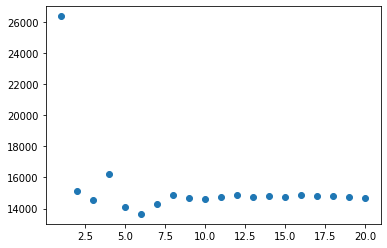

In [26]:
import matplotlib.pyplot as plt
plt.scatter(hyper_params, mse_values)

En un principio decrece para luego volver a crecer. Esto es muy típico.

El menor valor corresponde a 6.

Ahora podemos probar a hacer lo mismo con la lista entera de features a ver qué diferencia hay.

[23303.759954493744, 14917.940273037542, 15006.17772721527, 15449.652801478953, 15291.714448236631, 15477.23381999747, 14962.337558914352, 15127.307824943116, 15088.43767468644, 14827.991319681452, 14711.46334583815, 14804.073702755657, 14877.339789028683, 14972.467100833506, 14961.879393249905, 15071.084271011092, 15096.083824415131, 15256.588224553716, 15216.990416583942, 15211.60953924915]


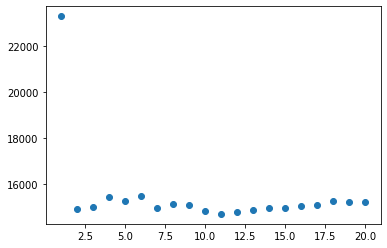

In [27]:
hyper_params = [x for x in range(1,21)]
mse_values = list()

features = train_df.columns.tolist()
features.remove('price')

for k in hyper_params:
    knn = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute')
    
    knn.fit(train_df[features], train_df['price'])
    
    predictions = knn.predict(test_df[features])
    
    mse_values.append(mean_squared_error(test_df['price'], predictions))
    
    
    
print(mse_values)

plt.scatter(hyper_params, mse_values)

Vemos que el workflow general es :
- Seleccionar features relevantes para el target.

- Usar grid search para encontrar el hiperparam óptimo

- Evaluar precisión y repetir

Vamos a estudar el comportamiento con 2 features y 3 features

In [28]:
two_features = ['accommodates', 'bathrooms']
three_features = ['accommodates', 'bathrooms', 'bedrooms']
hyper_params = [x for x in range(1,21)]
# Append the first model's MSE values to this list.
two_mse_values = list()
# Append the second model's MSE values to this list.
three_mse_values = list()
two_hyp_mse = dict()
three_hyp_mse = dict()

temp_dict = {}

for k in hyper_params:
    
    knn = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute')
    
    knn.fit(train_df[two_features], train_df['price'])
    
    predictions = knn.predict(test_df[two_features])
    
    mse = mean_squared_error(test_df['price'], predictions)
    two_mse_values.append(mse)
    
    temp_dict[k] = mse
    

two_hyp_mse = {min(temp_dict, key=temp_dict.get) : temp_dict[min(temp_dict, key=temp_dict.get)]}



temp_dict_3 = {}

for k in hyper_params:
    
    knn = KNeighborsRegressor(n_neighbors = k, algorithm = 'brute')
    
    knn.fit(train_df[three_features], train_df['price'])
    
    predictions = knn.predict(test_df[three_features])
    
    mse = mean_squared_error(test_df['price'], predictions)
    three_mse_values.append(mse)
    
    temp_dict_3[k] = mse
    

three_hyp_mse = {min(temp_dict_3, key=temp_dict_3.get) : temp_dict_3[min(temp_dict_3, key=temp_dict_3.get)]}

print(two_hyp_mse)
print(three_hyp_mse)


{5: 14790.314266211606}
{5: 13522.893333333333}


Vemos que mejora respecto a usar 4 features y es mejor que usar una sola. Lo mejor parece ser utilizar varias features pero sin necesidad de usar todas.

### Cross Validation

Anteriormente hemos visto train/test validation para medir la precisión de un modelo.

Vamos a ver otras técnicas robustas de validación.

#### Holdout Validation

- Dividimos el data set en 2 sets a 50%.
- Usamos un set como training y otro como test, computamos error
- Cambiamos el rol de los sets, computamos error
- Hacmos promedio de los dos

De esta manera se elimina el número de obsrvaciones como posible fuente de variación en el rendimiento del modelo.

In [29]:
import numpy as np
import pandas as pd

dc_listings = pd.read_csv("dc_airbnb.csv")
stripped_commas = dc_listings['price'].str.replace(',', '')
stripped_dollars = stripped_commas.str.replace('$', '')
dc_listings['price'] = stripped_dollars.astype('float')
shuffled_index = np.random.permutation(dc_listings.index)
dc_listings = dc_listings.reindex(shuffled_index)

split_one = dc_listings.iloc[0:1862].copy()
split_two = dc_listings.iloc[1862:].copy()

Hacemos entrenamiento y testeo con los dos sets

In [30]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

train_one = split_one
test_one = split_two
train_two = split_two
test_two = split_one
# First half
model = KNeighborsRegressor()
model.fit(train_one[["accommodates"]], train_one["price"])
test_one["predicted_price"] = model.predict(test_one[["accommodates"]])
iteration_one_rmse = mean_squared_error(test_one["price"], test_one["predicted_price"])**(1/2)

# Second half
model.fit(train_two[["accommodates"]], train_two["price"])
test_two["predicted_price"] = model.predict(test_two[["accommodates"]])
iteration_two_rmse = mean_squared_error(test_two["price"], test_two["predicted_price"])**(1/2)

avg_rmse = np.mean([iteration_two_rmse, iteration_one_rmse])

print(iteration_one_rmse, iteration_two_rmse, avg_rmse)

131.6207283081407 128.77209995637674 130.19641413225872


#### K-fold Cross-Validation

En realidad el holdout validation es un caso específico del k-fold cross-validation cuando k es 2.

Este usa una parte más grande de los datos para el training y va rotando entre diferentes subsets. Así se evitan ciertos problemas del train/test validation simple.

![title](imagenes/k-fold-cv.PNG)

Según aumente el número de divisiones, aumentará la varianza del error obtenido entre folds.

Dividimos el dataset añadiendo una columna "fold" por simplicidad

In [31]:
dc_listings.loc[dc_listings.index[0:745], "fold"] = 1
dc_listings.loc[dc_listings.index[745:1490], "fold"] = 2
dc_listings.loc[dc_listings.index[1490:2234], "fold"] = 3
dc_listings.loc[dc_listings.index[2234:2978], "fold"] = 4
dc_listings.loc[dc_listings.index[2978:3723], "fold"] = 5

print(dc_listings['fold'].value_counts())
print("\n Num of missing values: ", dc_listings['fold'].isnull().sum())

5.0    745
2.0    745
1.0    745
4.0    744
3.0    744
Name: fold, dtype: int64

 Num of missing values:  0


Hacemos k-fold cv en un modelo simple univariante:

In [32]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

knn = KNeighborsRegressor()

knn.fit(dc_listings[dc_listings['fold'] != 1][['accommodates']], dc_listings[dc_listings['fold'] != 1]['price'])


labels = knn.predict(dc_listings[dc_listings['fold'] == 1][['accommodates']])


iteration_one_rmse = mean_squared_error(dc_listings[dc_listings['fold'] == 1]['price'], labels) ** (1/2)

O de otra manera más detallada:

In [33]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
# Training
model = KNeighborsRegressor()
train_iteration_one = dc_listings[dc_listings["fold"] != 1]
test_iteration_one = dc_listings[dc_listings["fold"] == 1].copy()
model.fit(train_iteration_one[["accommodates"]], train_iteration_one["price"])

# Predicting
labels = model.predict(test_iteration_one[["accommodates"]])
test_iteration_one["predicted_price"] = labels
iteration_one_mse = mean_squared_error(test_iteration_one["price"], test_iteration_one["predicted_price"])
iteration_one_rmse = iteration_one_mse ** (1/2)

Hacemos una función para hacer el proceso de iteración más fácil.

Recibe como argumentos un data set y una lista de folds (Asume que el dataset ya tiene una columna con folds acorde) y devuelve una lista de rmses.

In [34]:
# Use np.mean to calculate the mean.
import numpy as np
fold_ids = [1,2,3,4,5]
def train_and_validate(df, folds):
    fold_rmses = []
    for fold in folds:
        # Train
        model = KNeighborsRegressor()
        train = df[df["fold"] != fold]
        test = df[df["fold"] == fold].copy()
        model.fit(train[["accommodates"]], train["price"])
        # Predict
        labels = model.predict(test[["accommodates"]])
        test["predicted_price"] = labels
        mse = mean_squared_error(test["price"], test["predicted_price"])
        rmse = mse**(1/2)
        fold_rmses.append(rmse)
    return(fold_rmses)

rmses = train_and_validate(dc_listings, fold_ids)
print(rmses)
avg_rmse = np.mean(rmses)
print(avg_rmse)

[112.04826596623559, 144.38561957805769, 124.88396829711334, 136.89503611883998, 112.45994078728297]
126.13456614950594


#### KFold Class en Scikit-Learn

Scikit Learn lo pone fácil para experimentar con hiperparam y evaluar su rendimiento.

LA [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html#sklearn.model_selection.KFold) class de sklearn.model_selection se instancia de manera similar que los modelos con unos parámetros.

En ella se pone el número de folds, si se hace un ordenamiento aleatorio del dataset, etc. 

````
from sklearn.model_selection import KFold
kf = KFold(n_splits, shuffle=False, random_state=None)


````

- n_splits is the number of folds you want to use,
- shuffle is used to toggle shuffling of the ordering of the observations in the dataset,
- random_state is used to specify the random seed value if shuffle is set to True.

Luego se pasa a la función [cross_val_score()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html) como parámetro junto al modelo que se haya elegido (p ej KNearestneighbor) así como los datos.

````
from sklearn.model_selection import cross_val_score
cross_val_score(estimator, X, Y, scoring=None, cv=None)
````

- estimator is a sklearn model that implements the fit method (e.g. instance of KNeighborsRegressor),
- X is the list or 2D array containing the features you want to train on,
- y is a list containing the values you want to predict (target column),
- scoring is a string describing the scoring criteria (list of accepted values here).
- cv describes the number of folds. Here are some examples of accepted values:
    - an instance of the KFold class,
    - an integer representing the number of folds.


El workflow general es:

- Instanciar modelo deseado de scikit-learn a hacer fit

- instanciar clase KFold con los parámetros deseados de k-fold cross-validation

- utilizar cross_val_score() para obtener la scoring metric

In [35]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits = 5, shuffle = True , random_state = 1)

knn = KNeighborsRegressor()

mses = cross_val_score(knn, dc_listings[['accommodates']], dc_listings['price'], scoring = 'neg_mean_squared_error', cv = kf )

avg_rmse = np.mean(np.sqrt(abs(mses)))

print(mses)
print(avg_rmse)

[-28321.07511409 -13829.76987919 -22768.27742282  -9285.8494086
 -12532.78451613]
129.01866963719164


Elegir el k adecuado es difícil.

Hemos visto que que **Holdout Validation** corresponde a k=2

Se conoce como **leave-one-out cross validation** cuando k = n, es decir el número de observaciones del dataset.

Tras mucha prueba y error, se ha visto que un valor estándar de k es 10.

Aquí vemos resultados de k de 3 a 23. Se ve que la desviación típica de RMSE aumenta según aumenta el número de folds.

In [36]:
from sklearn.model_selection import cross_val_score, KFold

num_folds = [3, 5, 7, 9, 10, 11, 13, 15, 17, 19, 21, 23]

#num_folds = [i for i in range(3,100)]

for fold in num_folds:
    kf = KFold(fold, shuffle=True, random_state=1)
    model = KNeighborsRegressor()
    mses = cross_val_score(model, dc_listings[["accommodates"]], dc_listings["price"], scoring="neg_mean_squared_error", cv=kf)
    rmses = np.sqrt(np.absolute(mses))
    avg_rmse = np.mean(rmses)
    std_rmse = np.std(rmses)
    print(str(fold), "folds: ", "avg RMSE: ", str(avg_rmse), "std RMSE: ", str(std_rmse))

3 folds:  avg RMSE:  133.39155832923973 std RMSE:  11.086603336206089
5 folds:  avg RMSE:  129.01866963719164 std RMSE:  26.49026525380437
7 folds:  avg RMSE:  128.2563631358857 std RMSE:  24.433778651168502
9 folds:  avg RMSE:  127.32586680970088 std RMSE:  37.14784717325374
10 folds:  avg RMSE:  125.76801286044285 std RMSE:  34.17044630953882
11 folds:  avg RMSE:  128.05794633376306 std RMSE:  28.189791000247233
13 folds:  avg RMSE:  135.19672255133156 std RMSE:  37.393562781262155
15 folds:  avg RMSE:  129.36948920791744 std RMSE:  32.19005631512455
17 folds:  avg RMSE:  129.95026068075245 std RMSE:  42.23205089616785
19 folds:  avg RMSE:  123.23092426546866 std RMSE:  36.25629204751065
21 folds:  avg RMSE:  123.74230115930078 std RMSE:  40.953451986202275
23 folds:  avg RMSE:  124.80660657221455 std RMSE:  44.4282428992255


#### Bias and Variance

Los modelos tienen dos fuentes de error: el sesgo y la varianza.

El Bias describe errores que resultan de malas asunciones sobre el algoritmo de aprendizaje. Por ejemplo considerar solo una feature para crear un modelo. Es una deficiencia del modelo. Se puede apreciar que hay un gran componente de bias si el error en el trainig set es similar al de test set, y ambos son mayores de lo que tenemos por objetivo. Es un underfitting. El RMSE promedio es un proxy de la componente de bias en el error.

La variance describe un error que ocurre debido a la variabilidad de las predicciones. Un modelo muy comlpejo que funciona muy bien con el training set pero mucho peor en el test set tiene un gran componente de error de varianza. Es un overfitting. LA desviación típica del RMSE es un proxy de la componente de varianza.

Siemrpe habrá un balance entre los dos tipos de error.

![title](imagenes/bias-variance.PNG)


## Calculus For Machine Learning

En el caso de KNN, es un algoritmo que no requiere de muchos conocimientos matemáticos para entender cómo funciona.

Sin embargo, no es útil aplicarlo a adatasets grandes porque el modelo se representa con el training set entero.

Es decir, cada vez que queramos hacer una predicción  en una nueva observación tenemos que calcular la distancia de la nueva observación respecto del training set entero. Luego hay que clasificar por distancia ascendente. Todo esto es computacionalemte costoso.

En la mayoría de las siguientes técnicas el modelo se representa como una función matemática. Esta función aproxima la función subyuacente qie rige cómo las features se relacionan con el atributo objetivo. Una vez sacada esta función, es computacionalmente barato hacer prediciones.

Hay que entender algunas ideas básicas de cálculo:

- Pendiente en un punto

- PUntos extremos de la función

- Determinar la función óptima que representa al dataset


Ponemos por ejemplo la función $ y = -x^2 + 3x - 1$

$y$ es la posición vertical de una pelota

$x$ es el tiempo


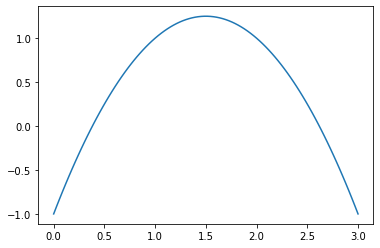

In [37]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,3,100)

y = -x*x + 3*x - 1

plt.plot(x,y)

Función lineal 

$y = mx + b$

$m$ slope

$b$ intercept

In [38]:
def slope(x1,x2,y1,y2):    
    return (y2- y1)/(x2-x1)

slope_one = slope(0,4,1,13)
slope_two = slope(5,-1,16,-2)

slope_one == slope_two

True

Una función no lineal como  $ y = -x^2 + 3x - 1$ obviamente no conserva la pendiente y cambios equivalentes en distancia en x tienen cambios muy distintos en y.


Dibujamos **secantes** de una curva: Línea que corta a una curva por dos puntos.

Si los puntos están muy cercanos la secante se aproxima muy bien a la curva, llegando a ser la pendiente en el caso extremo y se llama **tangente**, según se alejan divergen de la curva.

Representa el ratio de cambio instatáneao de la función y no se puede calcular con la fórmula anterior porque es una indeterminación

$m = \cfrac {y_2- y_1}{x_2-x_1} = \cfrac{0}{0}$



Esto nos indica que para funciones no lineales no es sificiente con tener dos puntos para poder sacar un modelo matemáqtico que aproxime la fución.

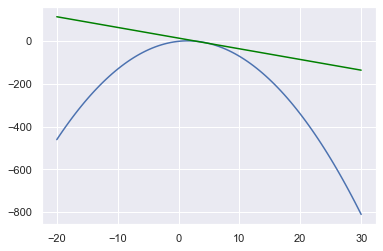

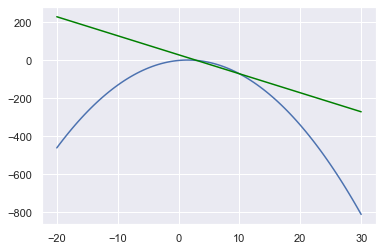

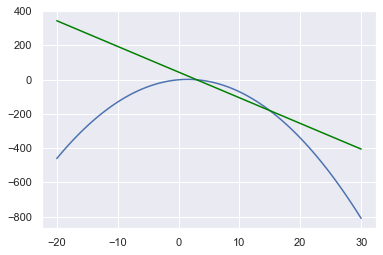

In [39]:
import seaborn
seaborn.set(style='darkgrid')

def draw_secant(x_values):
    x = np.linspace(-20,30,100)
    y = -1*(x**2) + x*3 - 1
    plt.plot(x,y)
    # Add your code here.
    x1 = x_values[0]
    x2 = x_values[1]
    y1 = -1*(x1**2) + x1*3 - 1
    y2 = -1*(x2**2) + x2*3 - 1
    
    m = (y2 - y1)/(x2 - x1)
    
    b = y1 - m * x1
    
    
    
    ys = m*x + b
    
    plt.plot(x, ys, 'green')
    plt.show()
    
    
draw_secant([3,5])

draw_secant([3,10])

draw_secant([3,15])

### Understanding Limits

No podemos calcular la pendiente directamente con $m = \cfrac{f(x_2)-f(x_1)}{x_2 - x_1} = \cfrac{0}{0}$.

Tenemos que aproximarnos por los lados y calcular el límite:


Si  $ f(x) = -x^2 + 3x - 1$, fijando $x_1$ a 3  calculamos cuánto vale la pendiente usando el límite : $lim_{x_2 \to 3} \cfrac{f(x_2) + 1}{x_2 - 3} = -3$

Es un límite inderterminado, lo podemos aproximar tomando números cercanos y hacer substitución directa.


| x1     | x0 | m       |
|--------|----|---------|
| 2.9    | 3  | -2.9    |
| 2.99   | 3  | -2.99   |
| 2.999  | 3  | -2.999  |
| 3.01   | 3  | -3.01   |
| 3.001  | 3  | -3.001  |
| 3.0001 | 3  | -3.0001 |

### SymPy librería de simbólicos

Unsamos sympy.symbols para declarar variables. El flujode trabajo es distinto a como hemos dibujado antes las funciones con linspace.


In [40]:
import sympy

x,y = sympy.symbols('x y')

y = x**2 + 1

print(y)



x**2 + 1


##### Calculando un límite con sympy

Tiene como entrada:

- La función que estamos estudiando

- La variable

- El valor al que nos aproximamos de la variable input
 

In [41]:
limit = sympy.limit(x**2 +1, x, 1)
print(limit)

2


In [42]:
import sympy
x2,y = sympy.symbols('x2 y')

y = (-x2**2) + 3*x2 - 1



limit_one = sympy.limit((y + 1)/(x2- 3), x2, 2.9)
print(limit_one)

-2.89999999999999


#### Convirtiendo un límite indefinido en definido

Tenemos una serie de propiedades:

$lim_{x \to a}\left[ f(x) + g(x)\right] = lim_{x \to a} f(x) + lim_{x \to a} g(x)  $

$lim_{x \to a}\left[ f(x) - g(x)\right] = lim_{x \to a} f(x) - lim_{x \to a} g(x)  $

In [43]:

import sympy
x,y = sympy.symbols('x y')

limit_two = sympy.limit(3*x**2 + 3*x -3, x, 1)

print(limit_two)

3


$lim_{x \to a} \left[c \space f(x) \right] = c\space lim_{x \to a} f(x) $

Podemos usar estas propiedades para transformar nuestro límite indeterminado en determinado:

$ lim_{x_2 \to 3}  \cfrac{f(x_2) + 1}{x_2 - 3} =  lim_{x_2 \to 3} \cfrac{ -x^2 + 3x}{x_2 - 3} = lim_{x_2 \to 3} -x_2 = -3$



### Finding Extreme Points

En esta ecuación de la pendiente $h$ representa la distancia entre dos puntos $x$ y $x + h$. La pendiente es el valor al que se aproxima el límite cuando $h$ se aproxima a 0. Esto se llama diferenciación o derivar.

$ m =  lim_{h \to 0}  \cfrac{f(x + h) - f(x)}{h}$

Por ejemplo para  $ f(x) = -x^2 + 3x - 1$, si la pasamos por la anterior ecuaciuón quedaría:

$m =  lim_{h \to 0}  -2x - h + 3 = -2x +3$ 

Que es otra ecuación que representa a la pendiente de la función

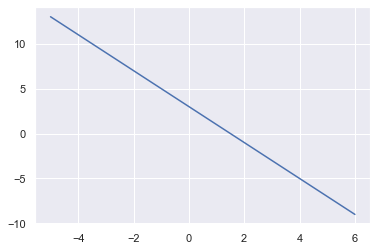

In [44]:
import matplotlib.pyplot as plt
import numpy as np

x = np.linspace(-5,6,110)

y = -2*x + 3

plt.plot(x,y)

#### Punto Crítico

Es donde la pendiente está indefinida o es 0.

#### Punto extremo

Cuando la pendinete es 0 y transiciona de signo de un lado al otro


Calcularemos las pendientes con las derivadas de las funciones y sus porpiedades de linearidad y de factor constante.

## Algebra For Machine Learning

El álgebra lineal es un método para representar y entender las soluciones a **sistemas de ecuaciones lineales**.

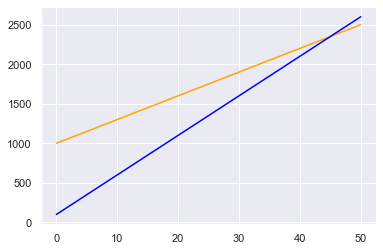

In [45]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,50,1000)

y1 = 30*x + 1000

y2 = 50*x +100

plt.plot(x,y1,'orange')

plt.plot(x,y2,'blue')

Para dos ecuaciones con dos variables es fácil resolver por método de eliminación.

Para mayor número de variables y ecuaciones utilizando una variación de eliminación llamada **Gaussian elimination**.

La forma general de un sistema de ecuaciones lineales es :

$Ax + By = c$

En las ecuaciones del sistema anterior la matriz aumentada sería:



$
\left[
  \begin{matrix}
    30 & -1 \\
    50 & -1 
  \end{matrix}
  \left|
    \,
    \begin{matrix}
      -1000  \\
      -100  \\      
    \end{matrix}
  \right.
\right]
$

In [46]:
matrix_one = np.asarray([
    [30, -1, -1000],
    [50, -1, -100]  
], dtype=np.float32)

In [47]:
matrix_one

array([[   30.,    -1., -1000.],
       [   50.,    -1.,  -100.]], dtype=float32)

Para resolver el sistema tenemos que convertir la matriz de coeficientes en la identidad. La mayoría de los sistemas no se podrá y serán indefinidos o no tendrán solución.

Se pueden hacer operaciones con las filas de la matriz para resolverlo, multiplicando constantes o sumando o restando filas. En numpy sería así:

In [48]:
matrix =  np.asarray([
    [1, 3],
    [50, 2]  
], dtype=np.float32)
# Swap the second row (at index value 1) with the first row (at index value 0).
matrix = matrix[[1,0]]

In [49]:
# Multipy the second row by 2.
matrix[1] = 2*matrix[1]

In [50]:
# Add the second row to the first row.
matrix[1] = matrix[1] + matrix[0]

Y ahora para nuestro sistema de antes

In [51]:
matrix_one = np.asarray([
    [30, -1, -500],
    [50, -1, -100]  
], dtype=np.float32)


matrix_one[0] = matrix_one[0]/30

In [52]:
matrix_one

array([[ 1.0000000e+00, -3.3333335e-02, -1.6666666e+01],
       [ 5.0000000e+01, -1.0000000e+00, -1.0000000e+02]], dtype=float32)

In [53]:
matrix_three = np.asarray([
    [1, -1/30, -1000/30],
    [0, 1, 2350]  
], dtype=np.float32)



matrix_three[0] = matrix_three[0] + matrix_three[1]/30

In [54]:
matrix_three

array([[1.0000000e+00, 0.0000000e+00, 4.5000004e+01],
       [0.0000000e+00, 1.0000000e+00, 2.3500000e+03]], dtype=float32)

### Vectors

Si una matriz es una tabla de números filas x columnas.

Cada fila/columna es una lista de números.

Cada lista de número es un vector.

Los vectores columna tienen operaciones asociadas y propiedades interesantes para los sitemas lineales.

A partir de ahora cuando consideramos vectores los vectores columna.

Un vector representa una dirección y una magnitud.



Para representar vectores en matplotlib podemos usar pyplot.quiver().

Tiene 4 parámetros: origen y destino.


````
plt.quiver(0, 0, 1, 2, angles='xy', scale_units='xy', scale=1)
````
Setting angles to 'xy' lets matplotlib know we want the angle of the vector to be between the points we specified. The scale_units and scale parameters lets us specify custom scaling parameters for the vectors


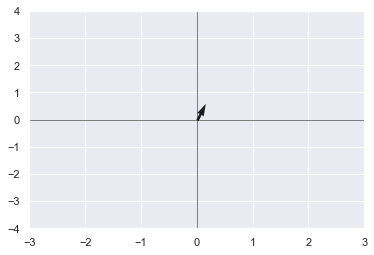

In [55]:
plt.axhline(0, c='black', lw=0.5)
plt.axvline(0, c='black', lw=0.5)
plt.xlim(-3,3)
plt.ylim(-4,4)

plt.quiver(0, 0, 1, 2)

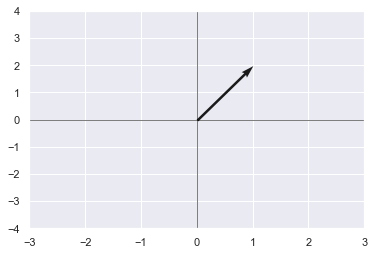

In [56]:
plt.axhline(0, c='black', lw=0.5)
plt.axvline(0, c='black', lw=0.5)
plt.xlim(-3,3)
plt.ylim(-4,4)

plt.quiver(0, 0, 1, 2, angles='xy', scale_units='xy', scale=1)

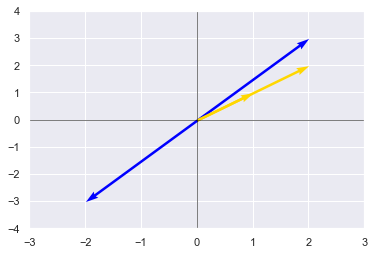

In [57]:
import matplotlib.pyplot as plt
import numpy as np

# This code draws the x and y axis as lines.

plt.axhline(0, c='black', lw=0.5)
plt.axvline(0, c='black', lw=0.5)
plt.xlim(-3,3)
plt.ylim(-4,4)

plt.quiver(0, 0, 2, 3, angles='xy', scale_units='xy', scale=1, color='blue')


plt.quiver(0, 0, -2, -3, angles='xy', scale_units='xy', scale=1, color='blue')


plt.quiver(0, 0, 1, 1, angles='xy', scale_units='xy', scale=1, color='gold')


plt.quiver(0, 0, 2, 2, angles='xy', scale_units='xy', scale=1, color='gold')

Adición y substracción de vectores:

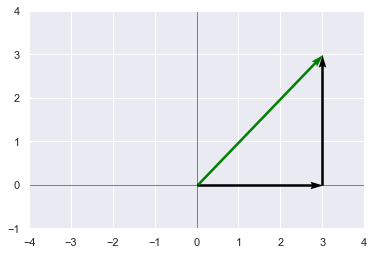

In [58]:
plt.axhline(0, c='black', lw=0.5)
plt.axvline(0, c='black', lw=0.5)
plt.xlim(-4,4)
plt.ylim(-1,4)

plt.quiver(0, 0, 3, 0, angles='xy', scale_units='xy', scale=1, color='black')

plt.quiver(3, 0, 0, 3, angles='xy', scale_units='xy', scale=1, color='black')

plt.quiver(0, 0, 3, 3, angles='xy', scale_units='xy', scale=1, color='green')

Scale vectors

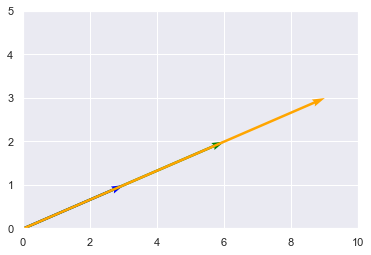

In [59]:
plt.axhline(0, c='black', lw=0.5)
plt.axvline(0, c='black', lw=0.5)
plt.xlim(0,10)
plt.ylim(0,5)



plt.quiver(0, 0, 3, 1, angles='xy', scale_units='xy', scale=1, color='blue')

plt.quiver(0, 0, 6, 2, angles='xy', scale_units='xy', scale=1, color='green')

plt.quiver(0, 0, 9, 3, angles='xy', scale_units='xy', scale=1, color='orange')

#### Vectores en NumPy

##### Combinación lineal

In [60]:
import numpy as np

vector_one = np.asarray([
    [1],
    [2],
    [1]
], dtype=np.float32)


vector_two = np.asarray([
    [3],
    [0],
    [1]
], dtype=np.float32)


vector_linear_combination = 2*vector_one + 5*vector_two
vector_linear_combination

array([[17.],
       [ 4.],
       [ 7.]], dtype=float32)

##### Producto escalar, dot product

Hay que representar uno de ellos como columna y otro como fila

In [61]:
dot_product = np.dot(vector_one[:,0], vector_two)
print(dot_product)

[4.]


#### Saber si un vector es combinación lineal de otros

Consiste en resolver las ecuaciones:

 
$
c_1
\left[
    \begin{matrix}
        3\\
        1
    \end{matrix} 
\right]
$
$
+
$
$
c_2
\left[
    \begin{matrix}
        1 \\
        2
    \end{matrix}
\right] 
=   
\left[
    \begin{matrix}
        4\\
        -2
    \end{matrix}
\right] 
$
  
  
![title](imagenes/linear_comb_1.PNG)
  
![title](imagenes/linear_comb_2.PNG)

In [62]:
w = np.asarray([
    [1],
    [2]
], dtype=np.float32)

v = np.asarray([
    [3],
    [1]
], dtype=np.float32)


end_point = 2*v - 2*w
print(end_point)

[[ 4.]
 [-2.]]


#### Resolución de sistemas de ecuaciones lineales

Las solución de sistemas de ecuaciones lineales se reduce a saber si el vector de la solución es combinación lineal de los vectores que forman parte de la matriz de coeficientes de las variables.


$A\vec{x} = \vec{b}$

$A$ es la matriz de coeficientes.

$\vec{x}$ es el vector solución.

$\vec{b}$ es el vector constante.

$ \left[\begin{matrix}
    30 & -1\\
    50 & -1
  \end{matrix} \right]    
  \left[\begin{matrix}
    x \\
    y
  \end{matrix}  \right] 
  =   
  \left[\begin{matrix}
    -1000\\
    -100
  \end{matrix} \right] 
  $

### Matrix Algebra

Las operaciones sobre vectores son aplicables sobre matrices.

In [63]:
matrix_a = np.asarray([
    [0.7, 3, 9],
    [1.7, 2, 9],
    [0.7, 9, 2]
], dtype=np.float32)

vector_b = np.asarray([
    [1],
    [2],
    [1]
], dtype=np.float32)



ab_product = np.dot(matrix_a, vector_b)

print(ab_product)

[[15.7]
 [14.7]
 [20.7]]


In [64]:
matrix_a = np.asarray([
    [0.7, 3],
    [1.7, 2],
    [0.7, 9]
], dtype=np.float32)

matrix_b = np.asarray([
    [113, 3, 10],
    [1, 0, 1],
], dtype=np.float32)

product_ab = np.dot(matrix_a, matrix_b)
print(product_ab)

print('\n')

product_ba = np.dot(matrix_b, matrix_a)
print(product_ba)

[[ 82.1         2.1        10.       ]
 [194.1         5.1000004  19.       ]
 [ 88.1         2.1        16.       ]]


[[ 91.2 435. ]
 [  1.4  12. ]]


#### Matriz transpuesta

$A^T + B^T = (A + B)^T$

$(AB)^T = B^TA^T$

In [65]:
matrix_a = np.asarray([
    [0.7, 3],
    [1.7, 2],
    [0.7, 9]
], dtype=np.float32)

matrix_b = np.asarray([
    [113, 3, 10],
    [1, 0, 1],
], dtype=np.float32)


transpose_a = np.transpose(matrix_a)
print(transpose_a)
print('\n')
print(np.transpose(transpose_a))

print('\n')

trans_ba = np.dot(np.transpose(matrix_b), transpose_a)
print(trans_ba)

print('\n')

trans_ab = np.dot( transpose_a, np.transpose(matrix_b))
print(trans_ab)

print('\n')

product_ab = np.dot(matrix_a, matrix_b)
print(product_ab)

print('\n')

product_ab == trans_ba

[[0.7 1.7 0.7]
 [3.  2.  9. ]]


[[0.7 3. ]
 [1.7 2. ]
 [0.7 9. ]]


[[ 82.1       194.1        88.1      ]
 [  2.1         5.1000004   2.1      ]
 [ 10.         19.         16.       ]]


[[ 91.2   1.4]
 [435.   12. ]]


[[ 82.1         2.1        10.       ]
 [194.1         5.1000004  19.       ]
 [ 88.1         2.1        16.       ]]




array([[ True, False, False],
       [False,  True, False],
       [False, False,  True]])

#### Matriz identidad

In [66]:
i_2 = np.identity(2)
i_3 = np.identity(3)

matrix_33 = np.asarray([
    [0.7, 3, 9],
    [1.7, 2, 9],
    [0.7, 9, 2]
], dtype=np.float32)

matrix_23 = np.asarray([
    [0.7, 3],
    [1.7, 2],
    [0.7, 9]
], dtype=np.float32)


identity_33 = np.dot(matrix_33, i_3)


identity_23 = np.dot(matrix_23, i_2)

print(identity_33 == matrix_33)

print(identity_23 == matrix_23)

[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]
[[ True  True]
 [ True  True]
 [ True  True]]


#### Matriz inversa

Solo se puede calcular en matrices cuadradas y con determinante no nulo

$I = A^{-1}A$

Para resolver un sistema de ecuaciones

$A^{-1}A\vec{x} = A^{-1}\vec{b}$

In [67]:
matrix_a = np.asarray([
    [1.5, 3],
    [1, 4]
])

def matrix_inverse_two(matrix2x2):
    determinant = matrix2x2[0][0] * matrix2x2[1][1] - matrix2x2[0][1] * matrix2x2[1][0]
    matrix = np.asarray([
    [matrix2x2[1][1],  - matrix2x2[0][1]],
    [- matrix2x2[1][0], matrix2x2[0][0]]
])
    try:
        inverse = 1/(determinant) * matrix
        return inverse
    except ValueError:
        print("determinant is 0")
        
inverse_a = matrix_inverse_two(matrix_a)

i_2 = np.dot(inverse_a, matrix_a)
print(i_2)

[[1. 0.]
 [0. 1.]]


##### np.linalg.inv()
Ahora para resolver el sistema de antes y de manera más general usamos np.linalg.inv()

In [68]:
A = np.asarray([
    [30, -1],
    [50, -1]  
], dtype=np.float32)

b = np.asarray([
    [-1000],
    [-100]  
], dtype=np.float32)


solution_x = np.dot(np.linalg.inv(A), b)

print(solution_x)

[[  45.]
 [2350.]]


#### Fórmula de la matriz inversa 3x3

Se utiliza la matriz adjunta, que es aplicable de manera general para nxn

![title](imagenes/inverse-of-3x3-matrix-formula.PNG)

#### Cálculo del determinante

Consiste en descomponer la matriz en matrices menores y calcular sus determinantes.

Para una de 3x3 sería
  
![title](imagenes/determinant.PNG)

La función de numpy es numpy.linalg.det()

In [69]:
matrix_22 = np.asarray([
    [8, 4],
    [4, 2]
])

matrix_33 = np.asarray([
    [1, 1, 1],
    [1, 1, 6],
    [7, 8, 9]
])


det_22 = np.linalg.det(matrix_22)

det_33 = np.linalg.det(matrix_33)

### Solution Sets

Hemos visto dos métodos para resolevr un sistema lineal:

- Eliminación Gaussiana

- Cálculo de matriz inversa de coeficientes

Ahora teneos que saber qué podemos ahcer con:

- Sistemas que no tienen solución

- Sistemas cuya solución no es un único vector

- Sistemas con $\vec{b} = 0$

#### Sistema inconsistente

Tiene dos o más ecuaciones que no se solapan sus valores.

Por ejemplo si tenemos la matriz aumentada:

$
\left[
  \begin{matrix}
    8 & 4 \\
    4 & 2 
  \end{matrix}
  \left|
    \,
    \begin{matrix}
      5  \\
      5  \\      
    \end{matrix}
  \right.
\right]
$

Si sacamos las ecuaciones asociadas y representamos las rectas que representan:

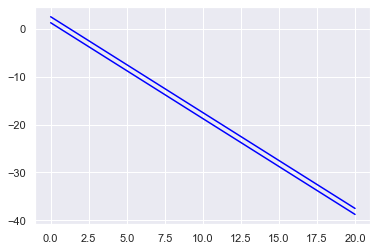

In [70]:
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(0,20, 1000)

y1 = -2*x + 5/4

y2 = -2*x + 5/2

plt.plot(x, y1, 'blue')

plt.plot(x, y2, 'blue')

Vemos que las rectas no se cruzan, por lo que el sistema no tiene solución.

El determinante de la matriz de coeficientes $A$ es 0.

#### Sistemas homogéneos

El vector constante es el vector nulo.

$
\left[
  \begin{matrix}
    8 & 4 \\
    4 & 2 
  \end{matrix}
  \left|
    \,
    \begin{matrix}
      0  \\
      0  \\      
    \end{matrix}
  \right.
\right]
$

Siempre tienen al menos una solución, el vector nulo. 

#### SIstema Cuadrado no-Homogéneo

Hay tres posibilidades:

- Sin solución
- Solución única
- Infinitas soluciones

![title](imagenes/square_non_homog.PNG)

#### Sistema rectangular no-homogéneo

Dos posibilidades

- Sin solución
- Infinitas soluciones


$
\left[
  \begin{matrix}
    1 & 0 & 3 \\
    0 & 1 & -1  
  \end{matrix}
  \left|
    \,
    \begin{matrix}
      1  \\
      1/2  \\      
    \end{matrix}
  \right.
\right]
$


$x_1 + 3x_3 = 1$

$x_2 - x_3 = 1/2 $

Queda $x_3$ como una variable libre

$x_1 = 1 - 3x_3  $

$x_2 =  1/2 +  x_3 $

El grupo de infinitas soluciones se llama el **espacio de soluciones**

La forma paramétrica sería 

$\vec{x} = x_3 \cdot
\left[
  \begin{matrix}
    4/3 \\
    0 \\
    1 
  \end{matrix}  
\right]
$

In [71]:
def test_homog(x3):
    x1 = 4/3*x3
    x2 = 0
    
    A = np.asarray([
    [1, 0, -4/3],
    [0, 1, 0],
    [0, 0, 0]
    ])
    
    x = np.asarray([
    [x1],
    [x2],
    [x3]
    ])
    
    null = np.asarray([
    [0],
    [0],
    [0]
    ])
    
    return(null == np.dot(A, x))

b_one = test_homog(1)

b_two = test_homog(-10)

##### Square vs. Rectangular

When A  is a square matrix, we can compute the determinant to determine if there's a solution and the matrix inverse if the determinant isn't equal to 0.

Unfortunately, computing the determinant and matrix inverse are very computationally intensive and should only be used for low dimensional matrices. These techniques are incredibly useful when working with small linear systems by hand, however.

When A is a rectangular matrix, we're looking to determine if the system has no solutions or infinitely many solutions using Gaussian elimination. If the latter, it's common to express the solution space in parametric vector form.

##### Nonhomogenous vs. Homogenous

When A is nonhomogenous, the linear system can contain zero, one, or infinitely many solutions. However, if A is rectangular and nonhomogenous, it can't contain just a unique solution (there will always be a free variable).

When A is homogenous, the linear system always contains the trivial solution (the zero vector). To determine if there's a solution space, we need to use Gaussian elimination to see if there are any inconsistent equations. If not, we can express the solution space in parametric form using the free variable.

## Linear Regression For Machine Learning

### The Linear Regression Model

A diferencia del KNN, este tipo de apredizaje se clasifica como **Machine Learning Paramétrico**.

Existen dos tipos fundamentales de algoritmos de aprendizaje: instance-based learning y parametric machine learning.

#### Instance Based Learning

Es el tipo de KNN.

No trata de capturar una relación entre feature y target.

utiliza la totalidad del training set en cada predicción.

No escala bien porque a mayor el data set más intensivo es el cálculo de distancias y ordenación de cada elemento que se pruebe en el test set.

![title](imagenes/instance_learning.PNG)

#### Parametric Machine Learning

Como linear regression o logistic regression.

El resultado del entrenamiento del modelo es una función matemática que aproxima lod patrones en el training set.

Esta función se le llama **modelo**.

En el modelo de regresión lineal la aproximación de la relación entre features y target es mediante una ecuación de regresión lineal.

$y = a_1x_1 + a_2x_2 + ... + a_nx_n$

La complejidad del cálculo para una predicción es uy inferior al modelo de KNN, da igual cómo de grande sea el data set.

![title](imagenes/parametric_learning.PNG)

Vamos atrabajar con el dataset  de casas vendidas en Ames, Iowa recopilado por Dean De Cock

AmesHousing.txt, cuyas columnas son:

- Lot Area: Lot size in square feet.
- Overall Qual: Rates the overall material and finish of the house.
- Overall Cond: Rates the overall condition of the house.
- Year Built: Original construction date.
- Low Qual Fin SF: Low quality finished square feet (all floors).
- Full Bath: Full bathrooms above grade.
- Fireplaces: Number of fireplaces.

[La documentación del dataset](https://s3.amazonaws.com/dq-content/307/data_description.txt)

In [72]:
import pandas as pd

data = pd.read_csv('AmesHousing.txt', delimiter = '\t')

train = data.loc[:1459]

test = data.loc[1460:]

data.info()

target = 'SalePrice'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2930 entries, 0 to 2929
Data columns (total 82 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Order            2930 non-null   int64  
 1   PID              2930 non-null   int64  
 2   MS SubClass      2930 non-null   int64  
 3   MS Zoning        2930 non-null   object 
 4   Lot Frontage     2440 non-null   float64
 5   Lot Area         2930 non-null   int64  
 6   Street           2930 non-null   object 
 7   Alley            198 non-null    object 
 8   Lot Shape        2930 non-null   object 
 9   Land Contour     2930 non-null   object 
 10  Utilities        2930 non-null   object 
 11  Lot Config       2930 non-null   object 
 12  Land Slope       2930 non-null   object 
 13  Neighborhood     2930 non-null   object 
 14  Condition 1      2930 non-null   object 
 15  Condition 2      2930 non-null   object 
 16  Bldg Type        2930 non-null   object 
 17  House Style   

#### Regresión Lineal Simple ( Caso univariante )


$\hat{y} = a_1x_1 + a_0$


$\hat{y}$ es la columna target

$x_1$ representa la columna feature

$a_0, a_1$ son los parámetros específicos al dataset

Sacamos la columna que podría ser la que mejor puede aprixomar el modelo con una sola variable

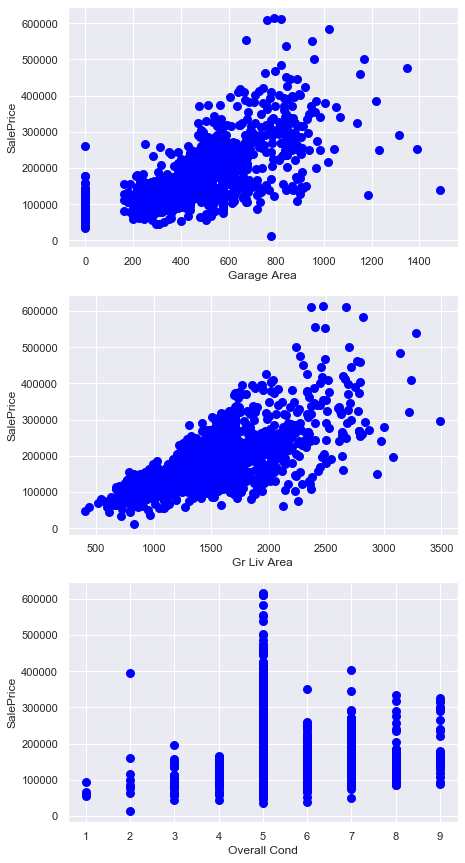

In [73]:
import matplotlib.pyplot as plt

columns = ['Garage Area', 'Gr Liv Area', 'Overall Cond']

fig = plt.figure(figsize=(7, 15))
for sp in range(0,3):
    ax = fig.add_subplot(3,1,sp+1)
    ax.scatter(train[columns[sp]], train['SalePrice'], label=sp, c='blue',  linewidth=3)   
    ax.set_xlabel(columns[sp])
    ax.set_ylabel('SalePrice')

plt.show()

Parece que la variable que mejor se correlaciona con el precio es **Gr Liv Area**.

Esto lo podemos calcular con la correlación entre pares de columnas con pandas.DataFrame.corr()

In [74]:
print(train[['Garage Area', 'Gr Liv Area', 'Overall Cond', 'SalePrice']].corr())

              Garage Area  Gr Liv Area  Overall Cond  SalePrice
Garage Area      1.000000     0.465366     -0.132401   0.662397
Gr Liv Area      0.465366     1.000000     -0.133710   0.698990
Overall Cond    -0.132401    -0.133710      1.000000  -0.099395
SalePrice        0.662397     0.698990     -0.099395   1.000000


#### Residual Sum Of Squares

Los parámetros óptimos se encuentran optimizando la suma de los residuos al cuadrado **RSS**.

Los residuos son la diferencia entre el valor predicho ($\hat{y}$) y el obtenido ($y$).

$RSS = (y_1 - \hat{y_1})^2 +  (y_2 - \hat{y_2})^2 + ... +  (y_n - \hat{y_n})^2 $

$RSS =\sum_{i=1}^n (y_i - \hat{y_i})^2$

$MSE = \cfrac{1}{n} \sum_{i=1}^n (y_i - \hat{y_i})^2$

In [75]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(train[['Gr Liv Area']], train['SalePrice'])

print(model.coef_)
print(model.intercept_)

a1 = model.coef_
a0 = model.intercept_


[116.86624683]
5366.821710056043


Por cada sqft de área que aumente el precio aumenta 116,67 dólares.

Ahora podemos predecir los elementos el test set

In [76]:
import numpy as np
from sklearn.metrics import mean_squared_error

lr = LinearRegression()
lr.fit(train[['Gr Liv Area']], train['SalePrice'])

prediction_train = lr.predict(train[['Gr Liv Area']])


prediction_test = lr.predict(test[['Gr Liv Area']])

train_rmse = np.sqrt(mean_squared_error(train['SalePrice'], prediction_train))

test_rmse = np.sqrt(mean_squared_error(test['SalePrice'], prediction_test))

print(train_rmse)

print(test_rmse)

56034.362001412796
57088.25161263909


#### Multiple Linear Regression

Ahora cogemos también las otras dos columnas de antes y entrenamos un modelo.

Vemos las diferencias.

In [77]:
cols = ['Overall Cond', 'Gr Liv Area']

lr = LinearRegression()
lr.fit(train[cols], train['SalePrice'])

prediction_train_2 = lr.predict(train[cols])

prediction_test_2 = lr.predict(test[cols])

train_rmse_2 = np.sqrt(mean_squared_error(train['SalePrice'], prediction_train_2))

test_rmse_2 = np.sqrt(mean_squared_error(test['SalePrice'], prediction_test_2))

print(train_rmse_2)

print(test_rmse_2)

56032.398015258674
57066.90779448559


### Feature Selection

Una vez seleccionado el modelo, lo sisguiente es seleccionar las features apropiadas.

Estudiamos:
- correlación entre features y target
- correlación entre features 
- varianza de features

Nos centramos en seleccionar features sin valres perdidos o que no necesitan transformaciones.

Primero eliminamos las columnas no numéricas y luego otras que son útiles en regresión

In [100]:

import pandas as pd
data = pd.read_csv('AmesHousing.txt', delimiter="\t")
train = data[0:1460]
test = data[1460:]


numerical_train = train.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64'])
numerical_train = numerical_train.drop(['PID', 'Year Built', 'Year Remod/Add', 'Garage Yr Blt', 'Mo Sold', 'Yr Sold'], axis=1)
null_series = numerical_train.isnull().sum()
full_cols_series = null_series[null_series == 0]
print(full_cols_series)

Order              0
MS SubClass        0
Lot Area           0
Overall Qual       0
Overall Cond       0
1st Flr SF         0
2nd Flr SF         0
Low Qual Fin SF    0
Gr Liv Area        0
Full Bath          0
Half Bath          0
Bedroom AbvGr      0
Kitchen AbvGr      0
TotRms AbvGrd      0
Fireplaces         0
Garage Cars        0
Garage Area        0
Wood Deck SF       0
Open Porch SF      0
Enclosed Porch     0
3Ssn Porch         0
Screen Porch       0
Pool Area          0
Misc Val           0
SalePrice          0
dtype: int64


In [102]:
len(full_cols_series)

25

Estudiar la correlación entre 25 features y target con una matriz de correlación es muy difícil, por lo que es mejor hacer correlación solo con el target.

In [103]:
train_subset = train[full_cols_series.index]
corrmat = train_subset.corr()
sorted_corrs = corrmat['SalePrice'].abs().sort_values()
print(sorted_corrs)

Misc Val           0.009903
3Ssn Porch         0.038699
Low Qual Fin SF    0.060352
Order              0.068181
MS SubClass        0.088504
Overall Cond       0.099395
Screen Porch       0.100121
Bedroom AbvGr      0.106941
Kitchen AbvGr      0.130843
Pool Area          0.145474
Enclosed Porch     0.165873
2nd Flr SF         0.202352
Half Bath          0.272870
Lot Area           0.274730
Wood Deck SF       0.319104
Open Porch SF      0.344383
TotRms AbvGrd      0.483701
Fireplaces         0.485683
Full Bath          0.518194
1st Flr SF         0.657119
Garage Area        0.662397
Garage Cars        0.663485
Gr Liv Area        0.698990
Overall Qual       0.804562
SalePrice          1.000000
Name: SalePrice, dtype: float64


#### Collinearity

Cuando dos features tienen mucha correlación están duplicando información sobre el target. No se necesita mantener ambas.

Por ejemplo, podemos poner un umbral de 0.3 en correlación con target para filtrar un poco más los features y luego ver qué colinearidad tienen las features.

Es bueno elegir y experimentar con umbrales de correlación como 0.3, e ir adaptando según resultados.

Una manera mejor que la matriz de correlación para ver la colinearidad es el seaborn.heatmap()

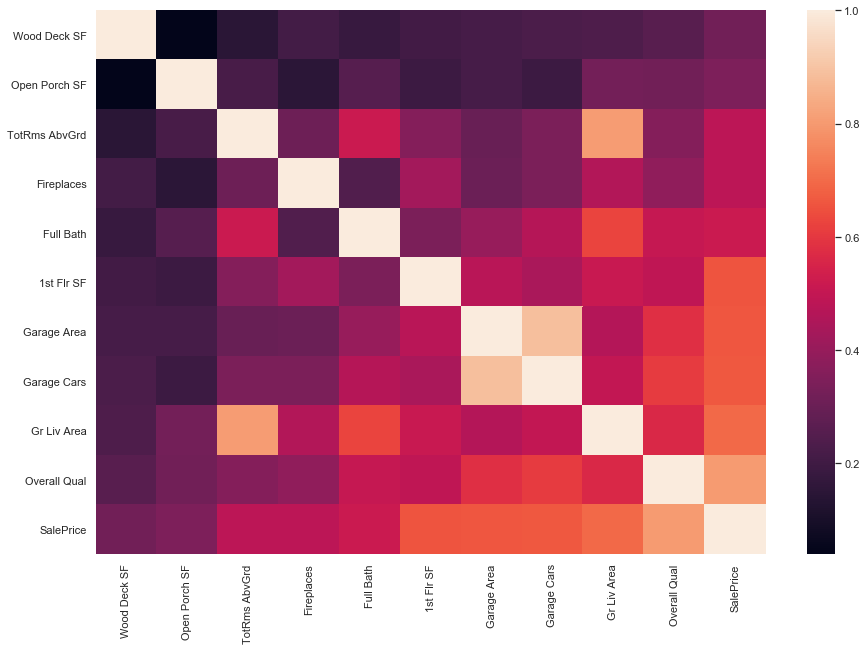

In [113]:
import seaborn as sns
import matplotlib.pyplot as plt

strong_corrs = sorted_corrs[sorted_corrs > 0.3]

corrmat = train_subset[strong_corrs.index].corr()

fig = plt.figure(figsize=(15,10))
sns.heatmap(corrmat)


Vemos que las columnas Gr Liv Area y TotRms AbvGrd tienen alta correlación.

Lo mismo pasa con garage Area y garage Cars.

Nos quedamos con las que son variables continuas y que ofrecen mayor detalle.

Es necesario también asegurarse de que el test set no tiene filas vacías.
Vemos que tiene una en garage Area así que eliminamos esa fila más adelante, antes de predecir en el test.

In [114]:
final_corr_cols = strong_corrs.drop(['Garage Cars', 'TotRms AbvGrd'])
print(test[final_corr_cols.index].info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 1460 to 2929
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Wood Deck SF   1470 non-null   int64  
 1   Open Porch SF  1470 non-null   int64  
 2   Fireplaces     1470 non-null   int64  
 3   Full Bath      1470 non-null   int64  
 4   1st Flr SF     1470 non-null   int64  
 5   Garage Area    1469 non-null   float64
 6   Gr Liv Area    1470 non-null   int64  
 7   Overall Qual   1470 non-null   int64  
 8   SalePrice      1470 non-null   int64  
dtypes: float64(1), int64(8)
memory usage: 103.5 KB
None


In [117]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np

final_corr_cols = strong_corrs.drop(['Garage Cars', 'TotRms AbvGrd'])
features = final_corr_cols.drop(['SalePrice']).index
target = 'SalePrice'

clean_test = test[final_corr_cols.index].copy()

clean_test.dropna(axis = 0, inplace = True)

lrm = LinearRegression()
lrm.fit(train[features], train[target])

train_predictions = lrm.predict(train[features])

test_predictions = lrm.predict(clean_test[features])

train_rmse = np.sqrt(mean_squared_error(train[target], train_predictions))

test_rmse = np.sqrt(mean_squared_error(clean_test[target], test_predictions))

print(train_rmse)

print(test_rmse)

34173.97629185852
41032.0261201977


#### Baja Varianza

Las columnas con poca varianza no contribuyen de manera importante a la capacidad del modelo para predecir.

Para poder comparar varianzas tenemos que reescalar los valores de manera que todos están comprendidos entre 0 y 1.

$x_{escalado} = \cfrac{x - min(x)}{max(x) - min(x)}$


In [119]:
unit_train = (train[features] - train[features].min())/(train[features].max() - train[features].min()) 

print(unit_train.min())

print(unit_train.max())

Wood Deck SF     0.0
Open Porch SF    0.0
Fireplaces       0.0
Full Bath        0.0
1st Flr SF       0.0
Garage Area      0.0
Gr Liv Area      0.0
Overall Qual     0.0
dtype: float64
Wood Deck SF     1.0
Open Porch SF    1.0
Fireplaces       1.0
Full Bath        1.0
1st Flr SF       1.0
Garage Area      1.0
Gr Liv Area      1.0
Overall Qual     1.0
dtype: float64


Vemos el valor de la varianza una vez escalado

In [121]:
print(unit_train.var())

Wood Deck SF     0.033064
Open Porch SF    0.013938
Fireplaces       0.046589
Full Bath        0.018621
1st Flr SF       0.025814
Garage Area      0.020347
Gr Liv Area      0.023078
Overall Qual     0.024496
dtype: float64


Open Porch SF es la que tienen menor varianza, mucho más lejos que los dos siguientes entre ellos.

In [122]:
clean_test = test[final_corr_cols.index].dropna()

features = features.drop('Open Porch SF')

lrm = LinearRegression()

lrm.fit(train[features], train[target])

train_predictions = lrm.predict(train[features])

train_rmse_2 = np.sqrt(mean_squared_error(train[target], train_predictions))

test_predictions = lrm.predict(clean_test[features])

test_rmse_2 = np.sqrt(mean_squared_error(clean_test[target], test_predictions))

print(train_rmse_2)

print(test_rmse_2)

34372.696707783965
40591.42702437726


### Gradient Descent

Un modelo de regresión lineal estima lña relación entre las features u la target y luego se utiliza para hacer predicciones.

Vamos a discutir los dos métodos más comunes para encontrar los valores óptimos de los parámetros para un modelo de regresi´pn lineal.

Encontrar los valores óptimos que forman un modelo se llama **model fitting**.

El objetivo es minimizar la función:

$MSE = \cfrac{1}{n} \sum_{i=1}^n (y_i - \hat{y_i})^2$


Un problema de optimización es el que consiste en elegir un set de valores que minimizan o maximizan otra función.

Empezamos con un modelo con un solo parámetro (no tiene $a_0$)

$\hat{y} = a_1x_1$

Si elegimos la variable GrLivArea podemos ver cómo evoluciona el error:

![title](imagenes/gradient_descent.PNG)


Esto se parece a buscar el mínimo relativo con cálculo. Sin embargo, no es tan sencillo como calcular la derivada cunado tenemos múltiples parámetros.

Tampoco podremos visualizar a partir de 3 parámetros.

Una solución interativa es el **Gradient Descent**. Este algoritmo prueba disintos valores de parámetro hasta que encuentra el menor MSE.

Proceso:

- Seleccionar valor inicial de $a_1$

- Repetir hasta convergencia (Número definido de iteraciones):

    - Calcular MSE con el $a_1$ actual : $MSE(a_1) = \cfrac{1}{n} \sum_{i=1}^n (y^{(i)} - \hat{y^{(i)}})^2 $
    - Calcular la derivada de MSE respecto al actual parámetro $\cfrac{d}{da_1}MSE(a_1)$
    - Actualizar el valor del parámetro restando la derivada por una constante $\alpha$ (learning rate): $a_1:=a_1 - \alpha \cfrac{d}{da_1}MSE(a_1)$.
        
        También se puede escribir esta asignación con flecha $a_1 \leftarrow a_1 - \alpha \cfrac{d}{da_1}MSE(a_1)$

La función que tratamos de optimizar con minimización es la **función de coste/ Cost Function**. También se suele utilizar el término **Loss Function** pero no son lo mismo: 

A loss function/error function is for a single training example/input. A cost function, on the other hand, is the average loss over the entire training dataset.

Si $\hat{y^{(i)}} = a_1x_1$


Si tenemos $MSE(a_1) = \cfrac{1}{n} \sum_{i=1}^n ( \hat{y^{(i)}} - y^{(i)})^2 = \cfrac{1}{n} \sum_{i=1}^n (  a_1x_{1}^{(i)} - y^{(i)})^2 $ y calculamos la derivada respecto a $a_1$

$\cfrac{d}{da_1}MSE(a_1) = \cfrac{2}{n} \sum_{i=1}^n x_{1}^{(i)} (a_1x_{1}^{(i)} - y^{(i)})^2$


Una vez conocido esto se utiliza el algoritmo del descenso de gradiente para encontrar un mínimo:

In [123]:
def derivative(a1, xi_list, yi_list):
    
    return (2/len(xi_list)*(xi_list*(a1*xi_list - yi_list))).sum()

def gradient_descent(xi_list, yi_list, max_iterations, alpha, a1_initial):
    a1_list = [a1_initial]

    for i in range(0, max_iterations):
        a1 = a1_list[i]
        deriv = derivative(a1, xi_list, yi_list)
        a1_new = a1 - alpha*deriv
        a1_list.append(a1_new)
    return(a1_list)

# Uncomment when ready.
param_iterations = gradient_descent(train['Gr Liv Area'], train['SalePrice'], 20, .0000003, 150)
final_param = param_iterations[-1]

In [124]:
final_param

120.14219147202736

Otra forma de hacer la función sería:

In [ ]:
def derivative(a1, xi_list, yi_list):
    len_data = len(xi_list)
    error = 0
    for i in range(0, len_data):
        error += xi_list[i]*(a1*xi_list[i] - yi_list[i])
    deriv = 2*error/len_data
    return deriv

Si ahora añadimos el parámetro intercept $a_0$ tendremos un sistema de regresión lineal simple:

SalePrice = $a_1$* GrLiveArea + $a_0$

![title](imagenes/gradient_descent_1.PNG)

Ahora la función de coste tendrán 2 parámetros $a_0$ y $a_1$

$MSE(a_1) = \cfrac{1}{n} \sum_{i=1}^n (  a_0 + a_1x_{1}^{(i)} - y^{(i)})^2 $


Ahora tenemos dos reglas de actualización para nuestros parámetros:


 $a_0 \leftarrow a_0 - \alpha \cfrac{d}{da_0}MSE(a_0)$

 $a_1 \leftarrow a_1 - \alpha \cfrac{d}{da_1}MSE(a_1)$


Y habrá que calcular tantas derivadas como parámetros tengamos:


$\cfrac{d}{da_0}MSE(a_0) = \cfrac{2}{n} \sum_{i=1}^n  (a_0 + a_1x_{1}^{(i)} - y^{(i)})^2$


$\cfrac{d}{da_1}MSE(a_1) = \cfrac{2}{n} \sum_{i=1}^n x_{1}^{(i)} (a_1x_{1}^{(i)} - y^{(i)})^2$



In [126]:
def a1_derivative(a0, a1, xi_list, yi_list):
    len_data = len(xi_list)
    error = 0
    for i in range(0, len_data):
        error += xi_list[i]*(a0 + a1*xi_list[i] - yi_list[i])
    deriv = 2*error/len_data
    return deriv

def a0_derivative(a0, a1, xi_list, yi_list):
    len_data = len(xi_list)
    error = 0
    for i in range(0, len_data):
        error += a0 + a1*xi_list[i] - yi_list[i]
    deriv = 2/len_data * error
    
    return deriv

def gradient_descent(xi_list, yi_list, max_iterations, alpha, a1_initial, a0_initial):
    a1_list = [a1_initial]
    a0_list = [a0_initial]

    for i in range(0, max_iterations):
        a1 = a1_list[i]
        a0 = a0_list[i]
        
        a1_deriv = a1_derivative(a0, a1, xi_list, yi_list)
        a0_deriv = a0_derivative(a0, a1, xi_list, yi_list)
        
        a1_new = a1 - alpha*a1_deriv
        a0_new = a0 - alpha*a0_deriv
        
        a1_list.append(a1_new)
        a0_list.append(a0_new)
    return(a0_list, a1_list)

# Uncomment when ready.
a0_params, a1_params = gradient_descent(train['Gr Liv Area'], train['SalePrice'], 20, .0000003, 150, 1000)

In [127]:
a0_params

[1000,
 999.9729797812329,
 999.985903701066,
 999.980232547139,
 999.9832179015052,
 999.9821734177915,
 999.983004932363,
 999.9829631191217,
 999.9833278635107,
 999.98350334434,
 999.9837669324418,
 999.9839895042135,
 999.9842311701743,
 999.9844639472566,
 999.9847008623329,
 999.9849358510428,
 999.9851717365096,
 999.9854072044933,
 999.985642866808,
 999.9858784386378,
 999.986114052572]

In [128]:
a1_params

[150,
 105.34801721547944,
 126.13471917628125,
 116.45794862200977,
 120.96274606972909,
 118.86564116059868,
 119.84189984026605,
 119.38742488614261,
 119.59899502291616,
 119.50050320781361,
 119.54635359313434,
 119.52500879150305,
 119.53494516153384,
 119.53031930255781,
 119.53247255390217,
 119.53146994657168,
 119.53193647656232,
 119.53171908350993,
 119.53182007507831,
 119.53177285001942,
 119.53179462379771]

##### Los principales problemas en el descenso de gradiente serán

- Elegir los valores iniciales de los parámetros

- Elegir un learning rate adecuado (hyperparameter optimization)

### Ordinary Least Squares

Es una alternativa ala Gradient Descent.

A diferencia del GD, no requiere de múltiples iteraciones.

Cuando el número de parámetros crece (cientos), el GD no escala bien.

El OLS lo que hace es definir una fórmula directa para calcular los valores óptimos de los parámetros en notación matricial.

$Xa = \hat{y}$

$X$ es una matriz que representa las columnas del training set, $a$ es el vector que representa los valores de los parámetros e $\hat{y} es el vector de las predicciones$

![title](imagenes/OLS.PNG)

La fórula será:

$a = (X^TX)^{-1}X^Ty$


Esto es lo que hace Scikit-Learn con la instancia LinearRegression()

In [139]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

data = pd.read_csv('AmesHousing.txt', delimiter="\t")
train = data[0:1460]
test = data[1460:]

features = ['Wood Deck SF', 'Fireplaces', 'Full Bath', '1st Flr SF', 'Garage Area',
       'Gr Liv Area', 'Overall Qual']
X = train[features].copy()
X['bias'] = 1
X = X[['bias']+features]
y = train['SalePrice']

first_term = np.linalg.inv(
        np.dot(
            np.transpose(X), 
            X
        )
    )
second_term = np.dot(
        np.transpose(X),
        y
    )
ols_estimation = np.dot(first_term, second_term)
print(ols_estimation)

[-1.12764871e+05  3.78815268e+01  7.08698430e+03 -2.22197281e+03
  4.31853639e+01  6.48808564e+01  3.87112549e+01  2.45531837e+04]


A diferencia del **GD**, el **OLS** es una **closed form solution**, una solución de forma cerrada.

Esto es que la solución se puede computar aritméticamente con un número de operaciones matemáticas predecibles.

El GD depende de los valores, iniciales, el learning rate alfa, etc...

El error se representa con la letra espsilon $\epsilon$:

$\epsilon = \hat{y} - y$


$y = Xa - \epsilon$

Aquí tenemos dos incógnitas: $a$ e $\hat{y}$

Estamos buscando un modelo, representado por $a$ que minimiza el MSE entre $y$ e $\hat{y}$

La función de coste es es el MSE, que en forma matricial es:

$J(a) = \cfrac{1}{n}(Xa - y)^T(Xa - y)$

##### Dervivada de la Cost Function matricial

[Aquí hay una explicación de la derivación](https://eli.thegreenplace.net/2015/the-normal-equation-and-matrix-calculus/)


$\cfrac{dJ(a)}{da} = 2X^TXa - 2X^Ty$

Para encontrar el vector $a$ que minimiza la función $J(a)$ se iguala la derivada a 0

$2X^TXa - 2X^Ty = 0$

Quedando al final:

$a = (X^TX)^{-1}X^Ty$


##### Limitaciones del OLS

La mayor limitación es el tamaño del data set. Computar la inversa es muy intensivo, de complejidad casi $O(n^3)$ [complejidad](https://en.wikipedia.org/wiki/Computational_complexity_of_mathematical_operations#Matrix_algebra).

Cuando el número de elementos es mayor que pocos millones es mejor utilizar **Gradient DEscent**, ya que es lo sufficientemente flexible como para poner un threshold o una solución "suficientemente buena".

### Processing and Transforming Features

Vamos a explorar cómo transformar las features para que podeamos utilizarlas en nuestro modelo.

Este proceso se llama **feature engineering**.

Ayuda mucho saber sobre el tema específico (Real State por ejemplo), pero también hay estrategias universales.

Primero nos centramos en las columnas sin missing values y que no tienen el formato aecuado para regresión lineal.

Entre las columnas que no tengan missing values pueden aparecer otros problemas ocmo: 

- No numérico (Códiog de zona de una ciudad)
- Numérico pero no ordinal (Código Postal)
- Ordinal pero no representativo de la relación con el target (Año)

In [140]:
import pandas as pd

data = pd.read_csv('AmesHousing.txt', delimiter="\t")
train = data[0:1460]
test = data[1460:]

train_null_counts = train.isnull().sum()
print(train_null_counts)

df_no_mv = train.dropna(axis = 1)

Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage      249
                 ... 
Mo Sold             0
Yr Sold             0
Sale Type           0
Sale Condition      0
SalePrice           0
Length: 82, dtype: int64


Esto hace lo mismo:

In [141]:
import pandas as pd

data = pd.read_csv('AmesHousing.txt', delimiter="\t")
train = data[0:1460]
test = data[1460:]

train_null_counts = train.isnull().sum()
print(train_null_counts)
df_no_mv = train[train_null_counts[train_null_counts==0].index]

Order               0
PID                 0
MS SubClass         0
MS Zoning           0
Lot Frontage      249
                 ... 
Mo Sold             0
Yr Sold             0
Sale Type           0
Sale Condition      0
SalePrice           0
Length: 82, dtype: int64


#### Categorical Features

Si un feature está compuesto por un número limitado de valores representaods por strings se llama categorical feature.

Por ejemplo:


In [142]:
print(train['Utilities'].value_counts())

AllPub    1457
NoSewr       2
NoSeWa       1
Name: Utilities, dtype: int64


In [143]:
print(train['Street'].value_counts())

Pave    1455
Grvl       5
Name: Street, dtype: int64


In [144]:
print(train['House Style'].value_counts())

1Story    743
2Story    440
1.5Fin    160
SLvl       60
SFoyer     35
2.5Unf     11
1.5Unf      8
2.5Fin      3
Name: House Style, dtype: int64


Para utilizarlos se puede transformar en representaciones numéricas.

Pandas tiene un data type categorical.

In [145]:
text_cols = df_no_mv.select_dtypes(include=['object']).columns

for col in text_cols:
    print(col+":", len(train[col].unique()))    
    

MS Zoning: 6
Street: 2
Lot Shape: 4
Land Contour: 4
Utilities: 3
Lot Config: 5
Land Slope: 3
Neighborhood: 26
Condition 1: 9
Condition 2: 6
Bldg Type: 5
House Style: 8
Roof Style: 6
Roof Matl: 5
Exterior 1st: 14
Exterior 2nd: 16
Exter Qual: 4
Exter Cond: 5
Foundation: 6
Heating: 6
Heating QC: 4
Central Air: 2
Electrical: 4
Kitchen Qual: 5
Functional: 7
Paved Drive: 3
Sale Type: 9
Sale Condition: 5


In [150]:
for col in text_cols:    
    train[col] = train[col].astype('category')   
    


C:\Users\adrig\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [151]:
train['Utilities'].cat.codes.value_counts()

0    1457
2       2
1       1
dtype: int64

In [153]:
train['Utilities'].cat.codes.head(10)

0    0
1    0
2    0
3    0
4    0
5    0
6    0
7    0
8    0
9    0
dtype: int8

Cuando convertimos a categorical type, pandas asigna un número de 0 a n-1, siendo n el númerod e valores únicos de esa columna.

El problema es que esto viola una asunción de la regresión lineal: Que las features están correlacionadas lienalmente con el target.

Para un categorical no hay un significado numérico en el código asignado por pandas. Un incremento de 1 a 2 no significa nada en el target.

Los categóricos se utilizan para unicidad y exclusividad: la categoría 0 es diffeente a la categoría 1.

##### Dummy Coding

La solución típica es usar dummy coding.

En vez de tener una columna con n valores posibles, tenemos n columnas con dos valores posibles: 0 o 1.

Por defecto, pandas pondrá el nombre de la feature con _ seguido de cada posible categoría

| Utilities_AllPub | Utilities_NoSewr | Utilities_NoSeWa |
|------------------|------------------|------------------|
| 1                | 0                | 0                |
| 1                | 0                | 0                |
| 1                | 0                | 0                |
| 1                | 0                | 0                |

Nota:
(También se puede hacer con feagtures categóricas que ya están en numérico).


In [155]:
for col in text_cols:
    col_dummies = pd.get_dummies(train[col])
    train = pd.concat([train, col_dummies], axis=1)
    del train[col]

In [156]:
train.head()

,Order,PID,MS SubClass,Lot Frontage,Lot Area,Alley,Overall Qual,Overall Cond,Year Built,Year Remod/Add,...,ConLI,ConLw,New,Oth,WD,Abnorml,Alloca,Family,Normal,Partial
0,1,526301100,20,141.0,31770,NaN,6,5,1960,1960,...,0,0,0,0,1,0,0,0,1,0
1,2,526350040,20,80.0,11622,NaN,5,6,1961,1961,...,0,0,0,0,1,0,0,0,1,0
2,3,526351010,20,81.0,14267,NaN,6,6,1958,1958,...,0,0,0,0,1,0,0,0,1,0
3,4,526353030,20,93.0,11160,NaN,7,5,1968,1968,...,0,0,0,0,1,0,0,0,1,0
4,5,527105010,60,74.0,13830,NaN,5,5,1997,1998,...,0,0,0,0,1,0,0,0,1,0


#### Modificación de Columnas Numéricas

Por ejemplo el año de construcción de una casa no da mucha información, ya que ha podido venderse 10 o 20 años después.

Lo mismo pasa con año de remodelación

In [160]:
print(train[['Year Remod/Add', 'Year Built']][:10])

   Year Remod/Add  Year Built
0            1960        1960
1            1961        1961
2            1958        1958
3            1968        1968
4            1998        1997
5            1998        1998
6            2001        2001
7            1992        1992
8            1996        1995
9            1999        1999


Tiene más sentido capturar la diferencia de tiempo entre ambos eventos:

In [161]:
train['years_until_remod'] = train['Year Remod/Add'] - train['Year Built']

#### Missing Values

Cuando faltan datos tenemos dos opciones: Eliminar filas, Imputar valores

- Eliminar filas que les falte valores en columnas específicas:
    - Pro: solo queda info limpia
    - Con:   Se elimina información, disminuye precisión
- Imputar, o reemplazar valores perdidos con un estadístico descriptivo de la columna:
    - Pro: Se preservan observaciones en el modelo
    - COn: Puede aumentar el ruido
    
En general cuando hay más del 50% de missing values no se imputa nunca, un 25% también suele ser un valor de corte.

In [162]:
import pandas as pd

data = pd.read_csv('AmesHousing.txt', delimiter="\t")
train = data[0:1460]
test = data[1460:]

train_null_counts = train.isnull().sum()
df_missing_values = train[train_null_counts[(train_null_counts>0) & (train_null_counts<584)].index]

print(df_missing_values.isnull().sum())
print(df_missing_values.dtypes)

Lot Frontage      249
Mas Vnr Type       11
Mas Vnr Area       11
Bsmt Qual          40
Bsmt Cond          40
Bsmt Exposure      41
BsmtFin Type 1     40
BsmtFin SF 1        1
BsmtFin Type 2     41
BsmtFin SF 2        1
Bsmt Unf SF         1
Total Bsmt SF       1
Bsmt Full Bath      1
Bsmt Half Bath      1
Garage Type        74
Garage Yr Blt      75
Garage Finish      75
Garage Qual        75
Garage Cond        75
dtype: int64
Lot Frontage      float64
Mas Vnr Type       object
Mas Vnr Area      float64
Bsmt Qual          object
Bsmt Cond          object
Bsmt Exposure      object
BsmtFin Type 1     object
BsmtFin SF 1      float64
BsmtFin Type 2     object
BsmtFin SF 2      float64
Bsmt Unf SF       float64
Total Bsmt SF     float64
Bsmt Full Bath    float64
Bsmt Half Bath    float64
Garage Type        object
Garage Yr Blt     float64
Garage Finish      object
Garage Qual        object
Garage Cond        object
dtype: object


#### Imputación

Se realiza con pandas.DataFrame.fillna()

Como parámetro se pasa 0 o un estadístico como la media de las columnas

Seleccionamos las columnas tipo float:


In [163]:
float_cols = df_missing_values.select_dtypes(include=['float'])

float_cols = float_cols.fillna(float_cols.mean())

float_cols.isnull().sum()


Lot Frontage      0
Mas Vnr Area      0
BsmtFin SF 1      0
BsmtFin SF 2      0
Bsmt Unf SF       0
Total Bsmt SF     0
Bsmt Full Bath    0
Bsmt Half Bath    0
Garage Yr Blt     0
dtype: int64

## Machine Learning in Python: Intermediate

### Logistic Regression

En **Linear Regression** la variable dependiente, la que se trata de predecir (target) es ordenada y continua.

Esto no funciona bien para predecir variables discretas, es decir, para problemas de **clasificación**.

Estos problemas tienen un número limitado de posibles valores y estos se pueden representar mediante enteros. Cada entero sería una categoría y se puede utilizar para mapear estas variables respecto a la variable targert utilizando operaciones matemáticas.

Por ejemplo:

| Problem                                                                   | Sample Features                                    | Type        | Categories           | Numerical Categories |
|---------------------------------------------------------------------------|----------------------------------------------------|-------------|----------------------|----------------------|
| Should we accept this student based on their graduate school application? | College GPA, SAT Score, Quality of Recommendations | Binary      | Don't Accept, Accept | 0, 1                 |
| What is the most likely blood type of 2 parent's offspring?               | Parent 1's blood type, Parent 2's blood type.      | Multi-class | A, B, AB, O          | 1, 2, 3, 4           |



Por ahora nos centraremos en **clasificación binaria**: 0 o 1

En este caso se va a tratar de predecir la admisión en un U.S. graduate program según las puntuaciones "GRE" y "GPA".

El data set es admissions.csv, tiene 644 filas y 3 columnas

- gre - Applicant's Graduate Record Exam score. The GRE is a generalized test for prospective graduate students. Score ranges from 200 to 800.
- gpa - College grade point average. Continuous between 0.0 and 4.0.
- admit - Binary value

En primer lugar se hace solo con la columna "gpa"

In [166]:
import pandas as pd
import matplotlib.pyplot as plt

admissions = pd.read_csv('admissions.csv')
admissions.head()

,admit,gpa,gre
0,0,3.177277,594.102992
1,0,3.412655,631.528607
2,0,2.728097,553.714399
3,0,3.093559,551.089985
4,0,3.141923,537.184894


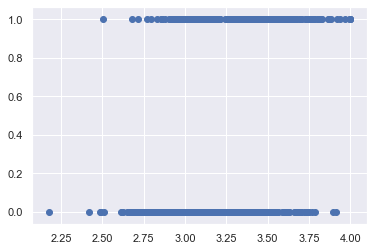

In [167]:


plt.scatter(admissions['gpa'], admissions['admit'])
plt.show()

Se ve que no existe ningún tipo de relación lineal entre gpa y admit.

Los valores 0 y 1 de admit representan valores binarios y no tienen ningún peso asociado.

Cuando los números se emplean para definir opciones (categprías) se llaman valores categóricos (**Categorical Values**).

Los problemas de **clasificación** se centran en estimar la relación entre las variables independientes (features) y la variable dependiente, que es una **Categorical Variable**.

La técnica utilizada es **Logistic Regression**.

Mientras que un modelo de regresión lineal da una salida de un número real (label), el modelo de logistic regression da una salida de probabilidad comprendida entre 0 y 1. Si la probabilidad es mayor que un threshold se asigna 1 o 0.



#### Logistic Function

En regresión lineal la relación entre features y target se define con la función lineal $y = mx + b$.

En logistic regression se define con la logistic function

$\sigma(t) = \cfrac{e^t}{1+ e^t}$

Está dividida en dos partes:

- Transformación Exponencial: Transforma los valores en positivo $e^t$
- Transformación de Normalización:  Transforma los valores para que estén en el rango 0 a 1 $ \cfrac{t}{1+t}$

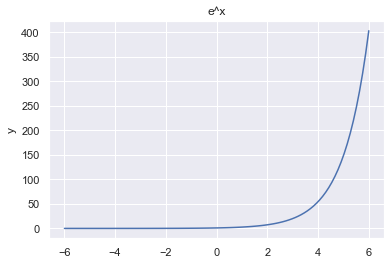

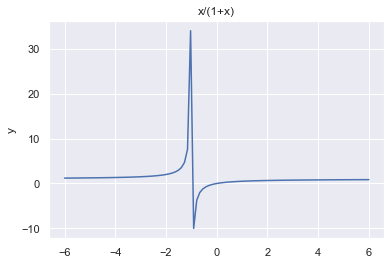

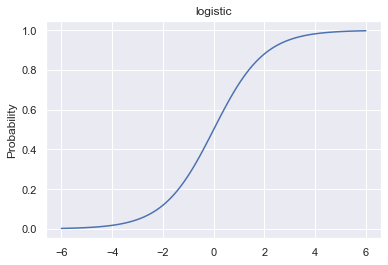

In [172]:
import numpy as np

# Generate 50 real values, evenly spaced, between -6 and 6.
x = np.linspace(-6,6,100, dtype=float)

# Exponential transformation
def exp(x):
    return np.exp(x)

# Transform each number in t using the Exponential transformation.
y = exp(x)

# Plot the resulting data.
plt.plot(x, y)
plt.ylabel("y")
plt.title('e^x')
plt.show()

# Normalization transformation
def norm(x):
    return x/(1+x)


# Transform each number in t using the Normalization transformation.
y = norm(x)

# Plot the resulting data.
plt.plot(x, y)
plt.ylabel("y")
plt.title('x/(1+x)')
plt.show()

# Logistic Function
def logistic(x):
    # np.exp(x) raises x to the exponential power, ie e^x. e ~= 2.71828
    return np.exp(x)  / (1 + np.exp(x)) 


# Transform each number in t using the logistic function.
y = logistic(x)

# Plot the resulting data.
plt.plot(x, y)
plt.ylabel("Probability")
plt.title('logistic')
plt.show()

#### Modelo LogisticRegression en Scikit-Learn

Es similar al proceso de la clase LinearRegression()

In [173]:
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(admissions[["gpa"]], admissions["admit"])

from sklearn.linear_model import LogisticRegression
logistic_model = LogisticRegression()
logistic_model.fit(admissions[['gpa']], admissions['admit'])

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

Para hacer predicciones se utiliza el método predict_proba().
Este método requiere de entrada una matriz de observaciones num_features x num_sample.

Para cada row de entrada, scikit edvuelve un array numpy con dos valores de probabilidad:
- La prob de que la row sea label 0
- La porb de que la row sea label 1

En este caso tenemos solo dos categorías

In [174]:
pred_probs = logistic_model.predict_proba(admissions[['gpa']])

In [177]:
pred_probs[:10]

array([[0.66343633, 0.33656367],
       [0.53967962, 0.46032038],
       [0.84160275, 0.15839725],
       [0.70338133, 0.29661867],
       [0.68063462, 0.31936538],
       [0.43719912, 0.56280088],
       [0.63238349, 0.36761651],
       [0.53555227, 0.46444773],
       [0.45718328, 0.54281672],
       [0.28091701, 0.71908299]])

In [183]:
pred_probs[0,1]

0.3365636690550385

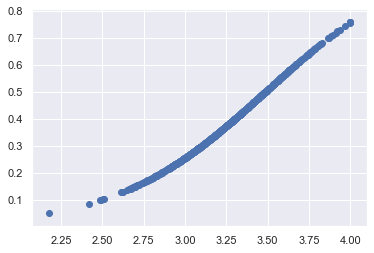

In [184]:
plt.scatter(admissions['gpa'], pred_probs[:,1])

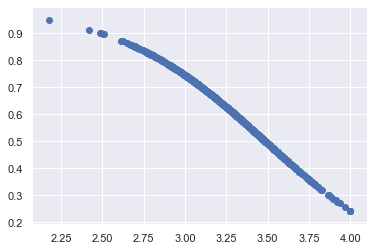

In [186]:
plt.scatter(admissions['gpa'], pred_probs[:,0])

Este gráfico sugiere una relación lineal entre los valores de GPA y la probavbilidad de ser admitido.

Esto es porque logistic regression es una **versión adaptada de regresión lineal para clasificación**.

##### Tanto logistic como linear regression se usan para capturar relaciones lineales entre las variables independientes y la variable dependiente.

#### Método predict()

Con el método predict(), en vez de dar una probabilidad se obtiene una label para cada row:

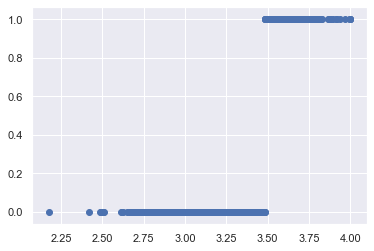

In [187]:
fitted_labels = logistic_model.predict(admissions[['gpa']])

plt.scatter(admissions['gpa'], fitted_labels)

### Introduction to Evaluating Binary Classifiers

In [218]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression

admissions = pd.read_csv("admissions.csv")
model = LogisticRegression()
model.fit(admissions[["gpa"]], admissions["admit"])

labels = model.predict(admissions[['gpa']])
admissions['predicted_label'] = labels

print(admissions['predicted_label'].value_counts())

admissions.head()

0    507
1    137
Name: predicted_label, dtype: int64


,admit,gpa,gre,predicted_label
0,0,3.177277,594.102992,0
1,0,3.412655,631.528607,0
2,0,2.728097,553.714399,0
3,0,3.093559,551.089985,0
4,0,3.141923,537.184894,0


En la columna admit está el valor real de la admisión y en predicted_label el predicho por el modelo.

En este formato es fácil calcular cómo de efectivo es el modelo:

$Accuracy = \cfrac{\# Correctly Predicted}{\# Observations}$

Por defecto, Scikit-Learn deja el threshold para calcular el label a partir de lka probabilidad calculada por la logistic function en 0.5.

In [219]:
admissions = admissions.rename(columns ={'admit':'actual_label'})

matches = admissions['actual_label'] == admissions['predicted_label']

correct_predictions = admissions[matches]

print(correct_predictions.head())

accuracy = len(correct_predictions)/len(admissions)

print(accuracy)

   actual_label       gpa         gre  predicted_label
0             0  3.177277  594.102992                0
1             0  3.412655  631.528607                0
2             0  2.728097  553.714399                0
3             0  3.093559  551.089985                0
4             0  3.141923  537.184894                0
0.6847826086956522


Esta accuracy no da mucha información, ya que está evaluada sobre el propio training set.

Hay que evaluarla sobre datos que el modelo nunca haya visto.

Hay cuatro posibles resultados en un problema de clasificación binaria:

| Prediction   | Observation         |                     |
|--------------|---------------------|---------------------|
|              | Admitted (1)        | Rejected (0)        |
| Admitted (1) | True Positive (TP)  | False Positive (FP) |
| Rejected (0) | False Negative (FN) | True Negative (TN)  |

Vamos a calcular el númerod e observaciones que hay en cada categoría de resultado

In [220]:
true_positives = len(admissions[(admissions['predicted_label'] == 1) & (admissions['actual_label'] == 1)])
true_negatives = len(admissions[(admissions['predicted_label'] == 0) & (admissions['actual_label'] == 0)])

print(true_positives)
print(true_negatives)

89
352


#### Sensitivity

Una manera más minuciosa de calcular el desempeño de un modelo es la sensibilidad.

La sensibilidad es el **True Positive Rate**, (En el ejemplo la proporción de solicitantes que fueron admitidos correctamente).

De todos los estudiantes que debería ser admitidos (TP + FN), qué fracción el modelo predijo correctamente.

$TPR = \cfrac{\text{True Positives}}{\text{False Negatives + True Positives}}$

Responde a la pregunta: **¿Cómo de efectivo es el modelo para identificar resultados positivos?**.

Es muy importante en problemas como predecir pacientes con cáncer o situaciones en las que conocer la postividad es crítica.



In [221]:
true_positive_filter = (admissions["predicted_label"] == 1) & (admissions["actual_label"] == 1)
true_positives = len(admissions[true_positive_filter])

false_negative_filter = (admissions['predicted_label'] == 0) & (admissions['actual_label'] == 1)
false_negatives = len(admissions[false_negative_filter])

sensitivity = true_positives / (true_positives + false_negatives)
print(sensitivity)

0.36475409836065575


#### Specificity

Responde a **¿Cómo de efectivo es el modelo para identificar resultados negativos?**

Indicaría la proporción de solicitantes que deberían ser rechazados y fueron correctamente rechazados.

$TNR = \cfrac{\text{True Negatives}}{\text{False Positives + True Negatives}}$


In [222]:
false_positive_filter = (admissions['predicted_label'] == 1)&(admissions['actual_label'] == 0)
false_positives = len(admissions[false_positive_filter])

specificity = true_negatives / (false_positives + true_negatives)
print(specificity)

0.88


### Multiclass Classification

En el ejemplo anterior el resultaod era binario, 0 o 1.

Ahora se estudia el caso de más de dos categorías de resultados.

El data set es auto-mpg.data dl repositorio de Machine Learning de UCI. [University of California Irvine on their machine learning repository](https://archive.ics.uci.edu/ml/datasets/Auto+MPG).

El csv es autocsv, ya filtrado omitiendo filas sin datos de miles per gallon.

Las columnas son:

- mpg -- Miles per gallon, Continuous.
- cylinders -- Number of cylinders in the motor, Integer, Ordinal, and Categorical.
- displacement -- Motor size, Continuous.
- horsepower -- Horsepower produced, Continuous.
- weight -- Car's weight, Continuous.
- acceleration -- Acceleration, Continuous.
- year -- Year the car was built, Integer and Categorical.
- origin -- Integer and Categorical. 1: North America, 2: Europe, 3: Asia.

Se va a tratar de predecir el origen del coche según el resto de variables.

In [229]:
import pandas as pd
cars = pd.read_csv("auto.csv")

unique_regions = cars['origin'].unique()
print(unique_regions)

[1 3 2]


Hay 3 columnas categóricas en el data set:

- cyclinders
- year
- origin 

La columna year es numérica, pero el año 71 y el 70 no se relaciónan de la misma manera que esos dos números se relacionan numéricamente. Son dos categorías distintas.

Lo mismo pasa con cylinders.

Pasamos estas columnas a dummy variables


In [232]:
pd.options.display.max_columns = 99

In [233]:
cars = pd.read_csv("auto.csv")

dummy_cylinders = pd.get_dummies(cars["cylinders"], prefix="cyl")
cars = pd.concat([cars, dummy_cylinders], axis=1)

dummy_years = pd.get_dummies(cars['year'], prefix='year')
cars = pd.concat([cars, dummy_years], axis = 1)

cars = cars.drop(['cylinders','year'], axis = 1)
                
cars.head()

,mpg,displacement,horsepower,weight,acceleration,origin,cyl_3,cyl_4,cyl_5,cyl_6,cyl_8,year_70,year_71,year_72,year_73,year_74,year_75,year_76,year_77,year_78,year_79,year_80,year_81,year_82
0,18.0,307.0,130.0,3504.0,12.0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,15.0,350.0,165.0,3693.0,11.5,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
2,18.0,318.0,150.0,3436.0,11.0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
3,16.0,304.0,150.0,3433.0,12.0,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
4,17.0,302.0,140.0,3449.0,10.5,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


#### One-Versus-All Method 

Hay múltiples  métodos o técnicas.

One-Versus-All es una técnica en la que elegimos una de las categorías como el caso **Positivo** y agrupamos el resto como **False**.

Se trata de partir el problema en múltiples clasificaciones binarias.

Cada observación tiene como salida del modelo la probabilidad de pertenecer a cada categoría

In [234]:
shuffled_rows = np.random.permutation(cars.index)
shuffled_cars = cars.iloc[shuffled_rows]

train_rows = int(len(shuffled_cars)*0.70)

train = shuffled_cars[:train_rows]
test = shuffled_cars[train_rows:]

Se divide el 3 problemas de clasificación binaria con 3 modelos distintos:

- Un modelo en que North America es Positivo 1 y Europe y Asia son Negativo 0.
- Un modelo en que Europe es Positivo 1 y North America y Asia son Negativo 0.
- Un modelo en que Europe es Asia 1 y North America y Europe son Negativo 0.

El que de mayor probabilidad será el que elijamos como predicted label.

In [238]:
from sklearn.linear_model import LogisticRegression

unique_origins = cars["origin"].unique()
unique_origins.sort()

models = {}
features = [c for c in train.columns if c.startswith("cyl") or c.startswith("year")]

for origin in unique_origins:
    model = LogisticRegression()
    
    X_train = train[features]
    y_train = train["origin"] == origin

    model.fit(X_train, y_train)
    models[origin] = model

Las predicciones con cada uno de los modelos:

In [239]:
testing_probs = pd.DataFrame(columns=unique_origins)

for origin in unique_origins:
    prediction = models[origin].predict_proba(test[features])
    testing_probs[origin] = prediction[:,1]

In [241]:
testing_probs.head(10)

,1,2,3
0,0.374398,0.392102,0.220660
1,0.817014,0.091240,0.072676
2,0.817014,0.091240,0.072676
3,0.310999,0.152146,0.531702
4,0.879196,0.060595,0.065045
5,0.871300,0.035527,0.113538
6,0.462760,0.116902,0.424534
7,0.817014,0.091240,0.072676
8,0.420428,0.305795,0.250728
9,0.400663,0.349722,0.233940


Ahora se elige el índice de la columna / origen de mayor probabilidad

In [242]:
predicted_origins = testing_probs.idxmax(axis = 1)

In [243]:
predicted_origins.head()

0    2
1    1
2    1
3    3
4    1
dtype: int64

### Overfitting

Para entender el overfitting hay que entender **Bias** y **Variance**

Ahora utilizamos el data set original auto-mpg.data, que requiere cierta limpieza previa.

In [255]:
import pandas as pd
columns = ["mpg", "cylinders", "displacement", "horsepower", "weight", "acceleration", "model year", "origin", "car name"]
cars = pd.read_table("auto-mpg.data", delim_whitespace=True, names=columns)
filtered_cars = cars[cars['horsepower'] != '?'].copy()
filtered_cars['horsepower'] = filtered_cars['horsepower'].astype('float')

In [257]:
filtered_cars.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


In [258]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           398 non-null    float64
 1   cylinders     398 non-null    int64  
 2   displacement  398 non-null    float64
 3   horsepower    398 non-null    object 
 4   weight        398 non-null    float64
 5   acceleration  398 non-null    float64
 6   model year    398 non-null    int64  
 7   origin        398 non-null    int64  
 8   car name      398 non-null    object 
dtypes: float64(4), int64(3), object(2)
memory usage: 28.1+ KB


In [259]:
filtered_cars.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 397
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   mpg           392 non-null    float64
 1   cylinders     392 non-null    int64  
 2   displacement  392 non-null    float64
 3   horsepower    392 non-null    float64
 4   weight        392 non-null    float64
 5   acceleration  392 non-null    float64
 6   model year    392 non-null    int64  
 7   origin        392 non-null    int64  
 8   car name      392 non-null    object 
dtypes: float64(5), int64(3), object(1)
memory usage: 30.6+ KB


#### Bias y Variance

Son las dos fuentes observables de error que podemos controlar indirectamente.

Un buen [artículo](http://scott.fortmann-roe.com/docs/BiasVariance.html)

##### Bias
El sesgo describe el error que resulta de malas asumciones en el algoritmo de aprendizaje.

Por ejemplo, asumir que una feature puede exlplicar el target en un modelo univariante, por ejemplo: solo el peso del coche se relaciona con la eficiencia en combustible. Esto resulta en un sesgo muy alto. El error será grande porque hay más variables que afectan.

##### Variance

La varianza describe un error que ocurre por la variabilidad de los valores predichos por el modelo.

Si tenemos un dataset de 1000 features y usamos todas en un modelo muy complejo, el resuyltado tendrá bajo bias pero alta variance.


Siempre hay un balance entre ambos

##### Overfitting

Ocurre cuando el modelo es eficaz en el training set pero no lo es para nuevos datos. Realmente es un concepto relativo, compara dos modelos.

Overfit captura el ruido a parte de la señal que queremos.

In [260]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

def train_and_test(cols):
    model = LinearRegression()
    model.fit(filtered_cars[cols], filtered_cars['mpg'])
    predictions = model.predict(filtered_cars[cols])
    variance = np.var(predictions)
    mse = mean_squared_error(filtered_cars['mpg'], predictions)
    return mse, variance


cols = ['cylinders']

cyl_mse, cyl_var = train_and_test(cols)



cols = ['weight']

weight_mse, weight_var = train_and_test(cols)

Ahora entrenamos modelos más complejos:

In [265]:
def train_and_test(cols):
    # Split into features & target.
    features = filtered_cars[cols]
    target = filtered_cars["mpg"]
    # Fit model.
    lr = LinearRegression()
    lr.fit(features, target)
    # Make predictions on training set.
    predictions = lr.predict(features)
    # Compute MSE and Variance.
    mse = mean_squared_error(filtered_cars["mpg"], predictions)
    variance = np.var(predictions)
    return(mse, variance)

features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year', 'origin']
one_mse, one_var = train_and_test(["cylinders"])
two_mse, two_var = train_and_test(features[:2])
three_mse, three_var = train_and_test(features[:3])
four_mse, four_var = train_and_test(features[:4])
five_mse, five_var = train_and_test(features[:5])
six_mse, six_var = train_and_test(features[:6])
seven_mse, seven_var = train_and_test(features[:7])

In [267]:
print(one_mse, one_var) 
print(two_mse, two_var) 
print(three_mse, three_var)
print(four_mse, four_var)
print(five_mse, five_var)
print(six_mse, six_var)
print(seven_mse, seven_var)

24.02017956815553 36.74255887416017
21.282057055586364 39.480681386729316
20.252954839714228 40.509783602601445
17.763860571843846 42.99887787047185
17.76139610540622 43.001342336909396
11.590170981415227 49.172567460900346
10.847480945000454 49.915257497315146


#### KFold Cross Validation
Para ver si un modelo está overfitting es útil comparar el in-sample error y el out-of-sample error

Haciendo cross validation se puede detectar fácilmente. Calculamos la media del mse y la varianza para cada fold.


In [287]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
import numpy as np

def train_and_cross_val(cols):
    features = filtered_cars[cols]
    target = filtered_cars['mpg']
    
    mse_values = []
    variance_values = []
    
    kf = KFold(n_splits=10, shuffle = True, random_state = 3)
    
    
    for train_index, test_index in kf.split(features):
        X_train, X_test = features.iloc[train_index],  features.iloc[test_index]
        y_train, y_test = target.iloc[train_index], target.iloc[test_index]
        
        
        lrm = LinearRegression()
        lrm.fit(X_train, y_train)
        
        predictions = lrm.predict(X_test)
                
        mse = mean_squared_error(y_test, predictions)
        
        variance_values.append(np.var(predictions))
        mse_values.append(mse)
        
    return np.mean(mse_values), np.mean(variance_values)

features = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year', 'origin']

two_mse, two_var = train_and_cross_val(features[:2])
three_mse, three_var = train_and_cross_val(features[:3])
four_mse, four_var = train_and_cross_val(features[:4])
five_mse, five_var = train_and_cross_val(features[:5])
six_mse, six_var = train_and_cross_val(features[:6])
seven_mse, seven_var = train_and_cross_val(features[:7])

In [288]:
print(one_mse, one_var) 
print(two_mse, two_var) 
print(three_mse, three_var)
print(four_mse, four_var)
print(five_mse, five_var)
print(six_mse, six_var)
print(seven_mse, seven_var)

24.02017956815553 36.74255887416017
21.584370274954374 38.902525313756016
20.655622193882955 40.091287956606934
18.169683239081884 42.50764364364439
18.283038517172052 42.59873630014678
12.099685425467118 48.92824696771803
11.418131971812054 49.90431373098729


Para ver qué está haciendo el kfold

In [286]:
features = filtered_cars[['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year', 'origin', ]]
target = filtered_cars['mpg']

kf = KFold(n_splits=2, shuffle= True, random_state = 3)
for a, b in kf.split(features):
    print(a,'\n', b)
    print('\n')
    print('\n')

[  0   1   2   7   8   9  11  12  13  17  19  20  22  26  28  32  33  34
  35  36  39  41  44  48  49  51  52  54  60  62  63  69  71  72  76  85
  86  87  88  89  90  91  92  93  94  95  96  97  99 100 104 106 110 111
 113 116 117 119 120 124 129 131 132 133 135 138 139 141 145 147 148 150
 152 156 158 160 161 164 165 167 169 171 172 173 174 175 176 178 179 181
 182 183 184 187 192 196 198 200 202 205 206 207 208 212 213 215 216 218
 219 222 223 226 232 233 235 237 242 248 249 252 253 256 257 258 262 264
 265 267 270 272 274 275 276 277 280 282 285 286 287 289 292 293 294 295
 300 301 302 304 306 308 311 312 314 315 316 318 320 321 322 324 325 326
 327 330 331 332 334 335 337 341 342 344 346 347 348 350 354 355 357 358
 359 360 362 363 364 365 367 368 370 374 377 379 381 386 389 390] 
 [  3   4   5   6  10  14  15  16  18  21  23  24  25  27  29  30  31  37
  38  40  42  43  45  46  47  50  53  55  56  57  58  59  61  64  65  66
  67  68  70  73  74  75  77  78  79  80  81  82  83  84

#### Bias / variance - continuacion

Durante el ejemplo, la cross validation, cuantas más features, menor es el error.

Esto es una buena señal, ya que indica que el modelo está generalizando bien para nuevos datos.

***Los modelos con menor mse son más complejos, pero suelen ser más sensibles a pequeñas variaciones en las entradas, tienen mayor varianza.**

El aumento en complejidad del modelo hace que sea más impredecible con ndatos nuevos desconocidos.

In [ ]:
print(one_mse, one_var) 
print(two_mse, two_var) 
print(three_mse, three_var)
print(four_mse, four_var)
print(five_mse, five_var)
print(six_mse, six_var)
print(seven_mse, seven_var)

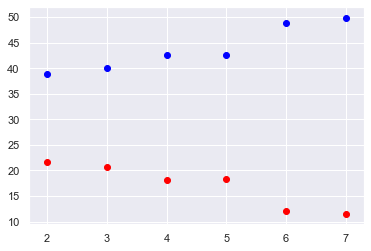

In [289]:
plt.scatter([2,3,4,5,6,7],[two_mse, three_mse, four_mse, five_mse, six_mse, seven_mse], c='red')


plt.scatter([2,3,4,5,6,7],[two_var, three_var, four_var, five_var, six_var, seven_var], c='blue')

### Clustering Basics


#### Supervised Machine Learning
Se basa en el entrenamiento de un modelo para hacer predicciones.

Lo que hemos visto hasta ahora de regresión y clasificación es aprendizaje supervisado.

#### Unsupervised Machine Learning
No se trata de predecir, sino de encontrar patrones en unos datos.

Una de las principales técnicas es el clustering. El clustering explora eld ataset y las relaciones emtre las columna y las filas.

Un ejemplo sería agrupar jugadores de la NBA según sus estadísticas:

![title](imagenes/clustering.PNG)



Vamos a estudiar datos de senadores de US basándose en qué votan.

EL dataset 114_congress.vsv tiene los resultados de los votos del 114th Senate.
Cada row es un senador.

Cada clumna es una votación.

0 es No, 1 es Yes, 0.5 es Abstención.

Columnas:

- name -- The Senator's last name.
- party -- The Senator's political party. The valid values are D for Democrat, R for Republican, and I for Independent.
- Several columns numbered like 00001, 00004, etc. Each of these columns represents the results of a single roll call vote.

In [1]:
import pandas as pd
votes = pd.read_csv('114_congress.csv')
votes.head()

,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
0,Alexander,R,TN,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
1,Ayotte,R,NH,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,Baldwin,D,WI,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0
3,Barrasso,R,WY,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,Bennet,D,CO,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [2]:
print(votes['party'].value_counts())

votes.mean().head()

R    54
D    44
I     2
Name: party, dtype: int64


00001    0.325
00004    0.575
00005    0.535
00006    0.945
00007    0.545
dtype: float64

Un resultado de la media de más de 0.5 es que hay más Yes que No.

#### Distancia Euclídea

Para agrupar senadores se puede calcular la distancia euclídea entre ellos.

$d = \sqrt{(q_1 - p_1)^2 + (q_2 - p_2)^2 + ... (q_n - p_n)^2}$

Se utilizan solo las columnas numéricas, obviamente.

In [7]:
from sklearn.metrics.pairwise import euclidean_distances

print(euclidean_distances(votes.iloc[0,3:].values.reshape(1, -1), votes.iloc[1,3:].values.reshape(1, -1)))

distance = euclidean_distances(votes.iloc[0,3:].values.reshape(1, -1), votes.iloc[2,3:].values.reshape(1, -1))
print(distance)

[[1.73205081]]
[[3.31662479]]


#### K-Means Clustering Intro

Vamos a utilizar el algoritmo de K-MEans de Scikit-Learn para ver el funcionamiento a alto nivel y más adelante se verá en detalle.

El algoritmo agrupa senadores se´gun similaridad de votos.

A cada cluster se le asigna un centro y se computa la distancia de cada senador a cada centro.

Se asignan a cluisters según proximidad

Intuimos que los senadores se agruparán según partidos, por eso ponemos k=2 como número de clusters.

Como no estamos predicionedo nada no existe el overfitting. Se entrena con el dataset entero.

Se inicializa el modelo:

````
kmeans_model = KMeans(n_clusters=2, random_state=1)

````

YSe aplica el método fit_transform() en el dataset.

El resultado serán dos columnas con las dos distancias a cada uno de los clusters:

````
array([[ 3.12141628,  1.3134775 ],
   [ 2.6146248 ,  2.05339992],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 1.43833966,  2.96866004],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 0.33960656,  3.41651746],
   [ 3.42004795,  0.24198446],
   [ 0.31287498,  3.30758755],
   ...
````

In [8]:
import pandas as pd
from sklearn.cluster import KMeans

kmeans_model = KMeans(n_clusters=2, random_state=1)

senator_distances = kmeans_model.fit_transform(votes.iloc[:,3:])

senator_distances[:10]

array([[1.3134775 , 3.12141628],
       [2.05339992, 2.6146248 ],
       [3.41651746, 0.33960656],
       [0.24198446, 3.42004795],
       [2.96866004, 1.43833966],
       [3.41651746, 0.33960656],
       [0.24198446, 3.42004795],
       [3.41651746, 0.33960656],
       [0.24198446, 3.42004795],
       [3.30758755, 0.31287498]])

##### Crosstab()

Para ver cómo se relacionan los clusters calculados con los partidos que ya se conocían en el dataset podemos utilizar el método crosstab().

Ejemplo ilustrativo de crosstab()

In [16]:
import numpy as np
is_smoker = np.array([0,1,1,0,0,1])
has_lung_cancer =  np.array([1,0,1,0,1,0])

pd.crosstab(is_smoker, has_lung_cancer, rownames = ['is_smoker'], colnames = ['has_lung_cancer'])

has_lung_cancer,0,1
is_smoker,,
0,1,2
1,2,1


Para el ejemplo del senado:

In [23]:
labels = kmeans_model.labels_


pd.crosstab(labels, votes['party'])

party,D,I,R
row_0,,,
0,3,0,54
1,41,2,0


Parece que 3 Demócratas han votado algo distinto que el resto de DEmócratas y que ningñun Republicano ha votado algo distinto de su partido.

Seleccionamos los 3 Demócratas outliers



In [24]:
democratic_outliers = votes[(labels == 0) & (votes['party'] == 'D')]
democratic_outliers

,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047
42,Heitkamp,D,ND,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
56,Manchin,D,WV,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0
74,Reid,D,NV,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


##### Representando en Matplotlib

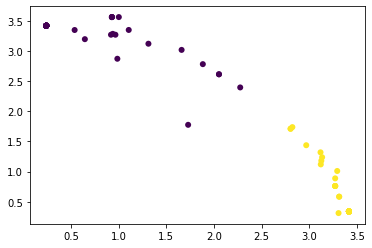

In [30]:
import matplotlib.pyplot as plt
plt.scatter(senator_distances[:,0], senator_distances[:,1], c=labels, linewidths = 0)


In [31]:
labels

array([0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0,
       1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1])

El array de labels tiene 2 valores distintos y el scatter lo interpreta como que cada valor es un color.

Se podría decir que los senadores más extremistas son aquellos que se encuentran lo más lejos de un cluster. Los que estén entre ambos clusters son más moderados.

##### Fórmula para encontrar extremistas

Se calcula el cubos de las distancias a los clusters.

Por ejemplo:

Un extremista sería e =\[3.4, 0.24], está muy lejos de un cluster comparado con otro y la suma 3.4 + 0.24 = 3.64

Un moderado sería m= \[2.6, 2], a una distancia parecida y la suma 2.6 + 2 = 4.6

Parecería que el moderado es más extremo

Sin embargo, sus cubos serían e**3 = [39.3, 0.013] y m**3 = [17.57, 8]

Y sus sumas 39.3 y 25.6, por lo que el extremista se identifica.

In [44]:
extremism = (senator_distances ** 3).sum(axis = 1)

votes['extremism'] = extremism

votes = votes.sort_values('extremism', ascending = False)

votes.head(10)

,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047,extremism
98,Wicker,R,MS,0.0,1.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.250476
53,Lankford,R,OK,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.046873
69,Paul,R,KY,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.046873
80,Sasse,R,NE,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.046873
26,Cruz,R,TX,0.0,1.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,46.046873
48,Johnson,R,WI,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540
47,Isakson,R,GA,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540
65,Murkowski,R,AK,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540
64,Moran,R,KS,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540
30,Enzi,R,WY,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.017540


In [45]:
votes.tail(10)

,name,party,state,00001,00004,00005,00006,00007,00008,00009,00010,00020,00026,00032,00038,00039,00044,00047,extremism
4,Bennet,D,CO,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,29.138297
56,Manchin,D,WV,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,28.234966
28,Donnelly,D,IN,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,27.758024
59,McCaskill,D,MO,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,27.073018
89,Tester,D,MT,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,27.073018
1,Ayotte,R,NH,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,26.532323
20,Collins,R,ME,0.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,26.532323
42,Heitkamp,D,ND,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,25.557841
78,Rubio,R,FL,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.5,0.5,0.5,0.5,0.5,24.655309
74,Reid,D,NV,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,10.784129


### K-means Clustering

Ahora se estudia el algoritmo de clustering en detalle.

Se utiliza el dataset de jugadores de NBA nba_2013.csv cuyas columnas son:

- player — the player's name
- pos — the player's position
- g — the number of games played
- pts — the player's total points scored
- fg. — the field goal percentage
- ft. — the free throw percentage

[La referencia del dataset](https://www.basketball-reference.com/leagues/NBA_2014_adj_shooting.html)

In [47]:
import pandas as pd
import numpy as np

nba = pd.read_csv("nba_2013.csv")
nba.head(3)

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,drb,trb,ast,stl,blk,tov,pf,pts,season,season_end
0,Quincy Acy,SF,23,TOT,63,0,847,66,141,0.468,...,144,216,28,23,26,30,122,171,2013-2014,2013
1,Steven Adams,C,20,OKC,81,20,1197,93,185,0.503,...,190,332,43,40,57,71,203,265,2013-2014,2013
2,Jeff Adrien,PF,27,TOT,53,12,961,143,275,0.520,...,204,306,38,24,36,39,108,362,2013-2014,2013


Primero nos vamos a centrar en dos features para simplificar la ilustración del clustering.

Seleccionamos solo los jugadores que juegan como point guards. Su labor es crear oportunidades de hacer canasta.

Por lo tanto el ratio que tienen entre Asistencias y Turnovers (perder el balón sin anotar) cuantifica su desempeño.

También los puntos que generan ellos mismos son una buena manera de evaluarlos.



In [58]:
point_guards = nba[nba['pos'] == 'PG'].copy()

Calculamos los puntos por partido de manora aproximada, porque no existe ese dato

In [59]:
point_guards['ppg'] = point_guards['pts'] / point_guards['g']

# Make sure ppg = pts/g
point_guards[['pts', 'g', 'ppg']].head(5)

,pts,g,ppg
24,930,71,13.098592
29,150,20,7.500000
30,660,79,8.354430
38,666,72,9.250000
50,378,55,6.872727


Eliminamos los jugadores con tov 0, ya que probablemente hayan jugado poco y no podemos hacer el ratio.

In [60]:
point_guards = point_guards[point_guards['tov'] != 0]

point_guards['atr'] = point_guards['ast'] / point_guards['tov']

En un scatter plot se pueden ver ambas variables y cómo caen los jugadores

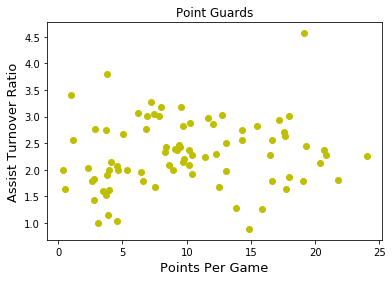

In [65]:

plt.scatter(point_guards['ppg'], point_guards['atr'], c='y')
plt.title("Point Guards")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

In [63]:
out = point_guards[point_guards['atr'] > 4]

In [64]:
out

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,ast,stl,blk,tov,pf,pts,season,season_end,ppg,atr
347,Chris Paul,PG,28,LAC,62,62,2171,406,870,0.467,...,663,154,4,145,157,1185,2013-2014,2013,19.112903,4.572414


#### Centroid Based Clustering

K-means es un algoritmo de clustering que es **centroid based**.

Esto quiere decir que funciona bien para clusters que tienden a tener forma de círculos con centros (centroides).

El centroide representa la media aritmética de todos los data points del cluster.

La K se refiere al número de clusters. Se puede elegir el k que más convenga en cada caso.

A priori hay 5 áreas generales para los Point Guards. Se pueden segmentar este grupo en subgrupos de jugaores similares.

El algoritmo es iterativo y va recalculando el valor del centroide de cada cluster y los jugadores que pertenecen aél. Para la primera iteración se cogen como centroides un número k(5) de jugadores.

In [66]:
num_clusters = 5
# Use numpy's random function to generate a list, length: num_clusters, of indices
random_initial_points = np.random.choice(point_guards.index, size=num_clusters)
# Use the random indices to create the centroids
centroids = point_guards.loc[random_initial_points]

In [67]:
centroids

,player,pos,age,bref_team_id,g,gs,mp,fg,fga,fg.,...,ast,stl,blk,tov,pf,pts,season,season_end,ppg,atr
273,Jeremy Lin,PG,25,HOU,71,33,2054,295,662,0.446,...,294,68,27,176,166,890,2013-2014,2013,12.535211,1.670455
279,John Lucas,PG,31,UTA,42,6,591,62,190,0.326,...,42,14,0,22,41,159,2013-2014,2013,3.785714,1.909091
136,Monta Ellis,PG,28,DAL,82,82,3023,576,1278,0.451,...,471,141,23,264,197,1560,2013-2014,2013,19.024390,1.784091
60,Avery Bradley,PG,23,BOS,60,58,1855,361,825,0.438,...,85,63,11,96,145,891,2013-2014,2013,14.850000,0.885417
87,Mario Chalmers,PG,27,MIA,73,73,2178,254,560,0.454,...,357,119,16,162,210,716,2013-2014,2013,9.808219,2.203704


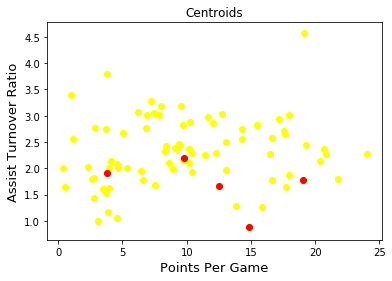

In [93]:
plt.scatter(point_guards['ppg'], point_guards['atr'], c='yellow')
plt.scatter(centroids['ppg'], centroids['atr'], c='red')
plt.title("Centroids")
plt.xlabel('Points Per Game', fontsize=13)
plt.ylabel('Assist Turnover Ratio', fontsize=13)
plt.show()

Creamos un diccionario de centroides actualziable en cada iteración

In [94]:
def centroids_to_dict(centroids):
    dictionary = dict()
    # iterating counter we use to generate a cluster_id
    counter = 0

    # iterate a pandas data frame row-wise using .iterrows()
    for index, row in centroids.iterrows():
        coordinates = [row['ppg'], row['atr']]
        dictionary[counter] = coordinates
        counter += 1

    return dictionary

centroids_dict = centroids_to_dict(centroids)

In [95]:
centroids_dict

{0: [12.535211267605634, 1.6704545454545454],
 1: [3.7857142857142856, 1.9090909090909092],
 2: [19.024390243902438, 1.7840909090909092],
 3: [14.85, 0.8854166666666666],
 4: [9.808219178082192, 2.2037037037037037]}

FUnción para calcular la distancia entre cada data point y un centroide

In [96]:
import math

def calculate_distance(centroid, player_values):
    root_distance = 0
    
    for x in range(0, len(centroid)):
        difference = centroid[x] - player_values[x]
        squared_difference = difference**2
        root_distance += squared_difference

    euclid_distance = math.sqrt(root_distance)
    return euclid_distance

q = [5, 2]
p = [3,1]

# Sqrt(5) = ~2.24
print(calculate_distance(q, p))

2.23606797749979


Ahora signamos los data points a clusters según la diustancia euclídea.

Dos soluciones: una la oficial y más bruta y otra la que hice yo, más corta

In [104]:
def assign_to_cluster(row):
    lowest_distance = None
    closest_cluster = None
    
    for cluster_id, centroid in centroids_dict.items():
        df_row = [row['ppg'], row['atr']]
        euclidean_distance = calculate_distance(centroid, df_row)
        
        if lowest_distance is None:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id 
        elif euclidean_distance < lowest_distance:
            lowest_distance = euclidean_distance
            closest_cluster = cluster_id
    return closest_cluster

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)


In [106]:
def assign_to_cluster(row):
    distances_centroid = dict()
    for centroid in centroids_dict:                
        distances_centroid[centroid] = calculate_distance(centroids_dict[centroid], [row['ppg'], row['atr']])    
    return min(distances_centroid, key=distances_centroid.get)

point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)

Visualizar los clusters

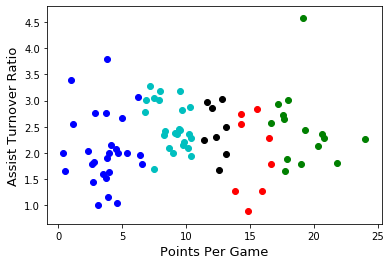

In [107]:
# Visualizing clusters
def visualize_clusters(df, num_clusters):
    colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

    for n in range(num_clusters):
        clustered_df = df[df['cluster'] == n]
        plt.scatter(clustered_df['ppg'], clustered_df['atr'], c=colors[n-1])
        plt.xlabel('Points Per Game', fontsize=13)
        plt.ylabel('Assist Turnover Ratio', fontsize=13)
    plt.show()

visualize_clusters(point_guards, 5)

Esto ha sido una iteración, ahora hau que recalcular los clusters de cada centroide con la media aritmética de sus miembros.

In [108]:
def recalculate_centroids(df):
    new_centroids_dict = dict()
    # 0..1...2...3...4
    for cluster_id in range(0, num_clusters):
        # Finish the logic
        new_centroids_dict[cluster_id] = [df[df['cluster'] == cluster_id]['ppg'].mean(), df[df['cluster'] == cluster_id]['atr'].mean()]
        
    return new_centroids_dict

centroids_dict = recalculate_centroids(point_guards)

Hacemos la siguiente iteración

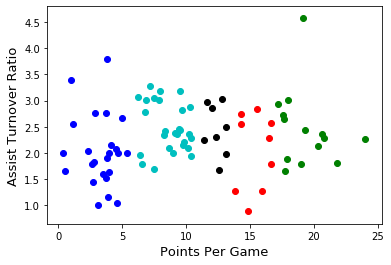

In [109]:
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)

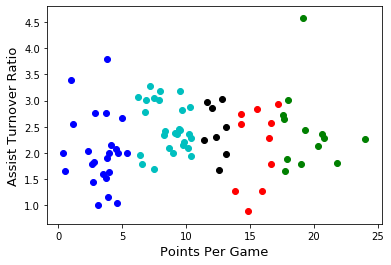

In [111]:
centroids_dict = recalculate_centroids(point_guards)
point_guards['cluster'] = point_guards.apply(lambda row: assign_to_cluster(row), axis=1)
visualize_clusters(point_guards, num_clusters)


Apenas ha cambiado en las dos últimas iteraciones. Esto significa que siempre convergerá.

Como K-means es conservadr entre iteraciones, es muy determinante la elección de centroides inicial.

Sklearn  ejecuta el algoritmo varias veces con distintos valores iniciales para minimizar este sesgo.



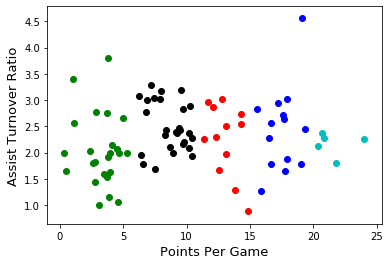

In [112]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=num_clusters)
kmeans.fit(point_guards[['ppg', 'atr']])
point_guards['cluster'] = kmeans.labels_

visualize_clusters(point_guards, num_clusters)

[5.582818825711082,
 3.66989507630336,
 11.928989824565118,
 8.026099521497176,
 2.8313958135441823]

## Decision Trees

### Introduction to Decision Trees

es un método de aprendizaje supervisado. Primero se contruye el árbol con datos históricos y luego se usa para predecir.

Una de las mayores ventajas es que puede captar interacciones no lineales entre variables de la manera en que regresión lineal no puede.

En el ejemplo, un árbol puede predecir que solo se debe luchar contra osos grandes si no puedes escapar.

![title](imagenes/decisiontree.PNG)

Se va a utilizar el dataset de ingresos individuales del censo de 1994 en US. Contiene información de estadoo matrimonial, edad, tipo de empleo, etc. La target sería determinar si un individuo gana más o menos de 50k al año.

[Dataset](http://archive.ics.uci.edu/ml/datasets/Adult)

In [114]:
import pandas

# Set index_col to False to avoid pandas thinking that the first column is row indexes (it's age)
income = pandas.read_csv("income.csv", index_col=False)
income.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [115]:
income['workclass'].value_counts()

 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Self-emp-inc         1116
 Federal-gov           960
 Without-pay            14
 Never-worked            7
Name: workclass, dtype: int64

Se ve que hay muchas variables categóricas. Es necesario convertirlas en numeric.

A cada label de categoría se le asigna un número.

En la conversión a categorical de pandas, éste muestra las labes como strings pero las guarda internamente ocmo números para hacer cálculos. Muchas veces los números no son compatibles ocn otras librerías (scikit), por lo que lo mejor es hacer la conversión directamente con  pandas.Categorical()

In [116]:
# Convert a single column from text categories to numbers
col = pandas.Categorical(income["workclass"])
income["workclass"] = col.codes
print(income["workclass"].head(5))

income['education'] = pandas.Categorical(income['education']).codes

income['marital_status'] = pandas.Categorical(income['marital_status']).codes

income['occupation'] = pandas.Categorical(income['occupation']).codes

income['relationship'] = pandas.Categorical(income['relationship']).codes

income['race'] = pandas.Categorical(income['race']).codes

income['sex'] = pandas.Categorical(income['sex']).codes

income['native_country'] = pandas.Categorical(income['native_country']).codes

income['high_income'] = pandas.Categorical(income['high_income']).codes

0    7
1    6
2    4
3    4
4    4
Name: workclass, dtype: int8


In [117]:
Esta comparación equivalcincome.head()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,high_income
0,39,7,77516,9,13,4,1,1,4,1,2174,0,40,39,0
1,50,6,83311,9,13,2,4,0,4,1,0,0,13,39,0
2,38,4,215646,11,9,0,6,1,4,1,0,0,40,39,0
3,53,4,234721,1,7,2,6,0,2,1,0,0,40,39,0
4,28,4,338409,9,13,2,10,5,2,0,0,0,40,5,0


Esta decisión equivaldría  a workclass != 4 para No y workclass == 4 para Sí

![title](imagenes/decisiontree_1.PNG)

In [118]:
private_incomes = income[income['workclass'] == 4]

public_incomes = income[income['workclass'] != 4]

Con cada split, el número de rows va disminuyendo en cada nodo

![title](imagenes/decisiontree_2.PNG)

Los nodos inferiores, donde se para de partir, se llaman terminal nodes o leaves (hojas).

El objetivo es asegurarse de que se puede h<cer una predicción en datos futuros. Cada hoja debe tener un valor de la columna target.

La target es high_income: 1 para >50 k , 0 para < 50k

CUando pasamos una row nueva por el árbol de decisión:

Primero se ve si la persona trabaja en private_sector, luego si es nativo de US, etc hasta llegar a la hoja.

En una hoja los valores de target de las rows que lleguen ahí deberían ser los misms.

#### Entropy

Cuando se va separando el dataset tendremos dos nuevos datasets.

En cada  uno de estos pasos lo que interesa es que en cada uno de los dos grupos haya homogeneidad del valor del target (high_income).

Para ello se utiliza la métrica de la entropía.

Cuanto más mezclados estén 0 y 1 en el target, más alta será la entropía.

La entropía de la Information Theory (No la de física) se basa en probabilidad, estadística y trata sobre transmisión, presamiento, utilziación y extracción de información.

Una unidad de información en este caso es un número binario, 1 o 0.

Si tenemos una moneda con 2 caras la entropía es 0, no se gana información tirándola. Si es una moneda normal, tirarla da un bit de información.

Cuando hay más de  2 posibilidadespuede ser muhco más compleja.

La fórmula es:

$-\sum_{i=1}^c P(x_i)log_bP(x_i)$

Se itera sobre cada valor único de una columna (high_income), $i$ es cada posible valor en una columna.

La probabilidad de que cada valor ocurra en los datos es $P(x_i)$.

La base del logaritmo $b$ se suele poner en 2.

````
age    high_income
25     1
50     1
30     0
50     0
80     1
````
$-\sum_{i=1}^c P(x_i)log_bP(x_i) = -((2/5*log_22/5)+ (3/5*log_23/5)) = 0.97$


Esto quiere decir que con esta clasificación hemos obtenido menos de un bit de información.

In [121]:
import math
# We'll do the same calculation we did above, but in Python
# Passing in 2 as the second parameter to math.log will take a base 2 log

prob_0 = income[income["high_income"] == 0].shape[0] / income.shape[0]
prob_1 = income[income["high_income"] == 1].shape[0] / income.shape[0]
income_entropy = -(prob_0 * math.log(prob_0, 2) + prob_1 * math.log(prob_1, 2))
income_entropy

0.7963839552022132

####   Surprise (Youtube StatQuest)

Es una manera de explicar la entropía comparándola con la "sorpresa" al encontrar una observación dentro de un conjunto.

La sorpresa no se puede definir como $\cfrac{1}{\text{probabilidad}}$ por los valores que encuentra en $P = 1$ y $P = 0$, por lo que se define como $surprise = log\cfrac{1}{p}$

Se ve el ejemplo de dos monedas raras, una que siempre es cara y ora que lo es con 0.9 prob.

![title](imagenes/surprise_1.PNG)
![title](imagenes/surprise_2.PNG)
![title](imagenes/surprise_3.PNG)
![title](imagenes/surprise_4.PNG)
![title](imagenes/surprise_5.PNG)
![title](imagenes/surprise_6.PNG)
![title](imagenes/surprise_7.PNG)
![title](imagenes/surprise_8.PNG)
![title](imagenes/surprise_9.PNG)


#### Information Gain

Nos dice qué variable es la que más reduce la entropía si se hace un split con ella.

$IG(T,A) = Entropy(T) - \sum_{v\in A}\cfrac{|T_v|}{|T|}Entropy(T_v)$

La $IG$ para una Target variable $T$ y para una variable spbre la que hacer split $A$.

Para cada valor $v$ de $A$ se computa el número de rows en las que $A$ tiene el valor $v$ y se divide por el número de rows y s emultiplica por la entropía de de las rows con $A = v$.

Es decir, se han hecho tantos subgrupos como distintos valores $v$ haya y se ha calculado la entropía en todos esos subgrupos. Se suman sus entropías y se resta de la entropía del conjunto original. Cada subgrupo se multiplica por su peso relativo en el conjunto.

Si el resultado es positivo quiere decir que con ese split se ha disminuído la entropía, el split produce una ganancia de información. (La entropía nueva es menor que la entropía antigua)

**La estrategia es crear árboles que tienen tantas ramas en cada nodo como valores únicos haya de la variable sobre la que estamos partiendo los datos***

Esto es complejo, para simplificar se puede partir por mayor o menor que el valor mediano de la variable en cuestión.

Si age <= 50 -> grupo 0 else grupo 1:

````

age    high_income    split_age
25     1              0
50     1              0
30     0              0
50     0              0
80     1              1


````

Tenemos dos grupos en los que en uno high_income es 1 1 0 0 y en el otro es 1. SI calculamos la entroía de ambos grupos, lo multiplicamos por su peso relativo y la restamos a la entropía del grupo antes de partirlo:

$IG(T,A) = Entropy(T) - \sum_{v\in A}\cfrac{|T_v|}{|T|}Entropy(T_v)  = 0.97 - ((((4/5) * - (2/4*log_22/4 + 2/4*log_22/4)) + -(1/5*(0*log_20 + 1*log_21))) = 0.97 - ((4/5)*-(-0.5-0.5)) + (1/5*-(0+1*0)) = 0.97 - 4/5 = 0.17$

Esto quiere decir que se han ganado 0.17 bits de información en el split.

In [123]:
import numpy

def calc_entropy(column):
    """
    Calculate entropy given a pandas series, list, or numpy array.
    """
    # Compute the counts of each unique value in the column
    counts = numpy.bincount(column)
    # Divide by the total column length to get a probability
    probabilities = counts / len(column)
    
    # Initialize the entropy to 0
    entropy = 0
    # Loop through the probabilities, and add each one to the total entropy
    for prob in probabilities:
        if prob > 0:
            entropy += prob * math.log(prob, 2)
    
    return -entropy

# Verify that our function matches our answer from earlier
entropy = calc_entropy([1,1,0,0,1])
print(entropy)

information_gain = entropy - ((.8 * calc_entropy([1,1,0,0])) + (.2 * calc_entropy([1])))
print(information_gain)


0.9709505944546686
0.17095059445466854


Aplicando a toda la columna de high income haciendo el mismo split con la mediana de age

In [130]:
median_age = income['age'].median()

left_split = income[income['age'] <= median_age]

right_split = income[income['age'] > median_age]

age_information_gain = (calc_entropy(income['high_income']) -
                        (left_split.shape[0]/ income['high_income'].shape[0] * calc_entropy(left_split['high_income']) + 
                         right_split.shape[0]/ income['high_income'].shape[0] * calc_entropy(right_split['high_income'])))

In [132]:
print(age_information_gain)

0.047028661304691965


Ahora lo que hay que hacer es buscar la columna que mayor IG tiene:

In [133]:
def calc_information_gain(data, split_name, target_name):
    """
    Calculate information gain given a data set, column to split on, and target
    """
    # Calculate the original entropy
    original_entropy = calc_entropy(data[target_name])
    
    # Find the median of the column we're splitting
    column = data[split_name]
    median = column.median()
    
    # Make two subsets of the data, based on the median
    left_split = data[column <= median]
    right_split = data[column > median]
    
    # Loop through the splits and calculate the subset entropies
    to_subtract = 0
    for subset in [left_split, right_split]:
        prob = (subset.shape[0] / data.shape[0]) 
        to_subtract += prob * calc_entropy(subset[target_name])
    
    # Return information gain
    return original_entropy - to_subtract

# Verify that our answer is the same as on the last screen
print(calc_information_gain(income, "age", "high_income"))


0.047028661304691965


In [134]:
columns = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "hours_per_week", "native_country"]

information_gains = []

for col in columns:
    information_gains.append(calc_information_gain(income, col, 'high_income'))
    
highest_gain = columns[information_gains.index(max(information_gains))]

In [135]:
print(highest_gain)

marital_status


Este algoritmo de árbol es el **ID3 algorithm**. hay otros como el **CART**, que usa diferentes medidas para el split.


NOTA:

Se ha aprendido a hacer un split, para hacer el árbos se hacn splits hasta que en las hojas quedan clases únicas de la variable target.

Si miramos el árbol de abajo vemos que en una hoja hay valor 0.5 del target, esto es porque hay dos rows (personas) de 50 años que cada uno tiene una target de high_income distinta (1 y 0). Si tuviésemos más variables se seguiría partiendo por ellas.

````
age    high_income
25     1
50     1
30     0
50     0
80     1
````

![title](imagenes/decisiontree_3.PNG)

### Building a Decision Tree

Se va a utilizar el algoritmo ID3 para construir un árbil.

Este algoritmo emplea recurividad y conocimiento de complejidad temporal.

LAs funciones recursivas se llaman a sí mismas y parten un problema en trozos más pequeños.

En cada nodo se llama a la función recursiva, que parte el dataset en dos (o más) ramas. Cada rama lleva a otro nodo y la función se llama otra vez en cada uno.

EL ID3 en pseudocódigo es:

````
def id3(data, target, columns)
    1 Create a node for the tree
    2 If all values of the target attribute are 1, Return the node, with label = 1
    3 If all values of the target attribute are 0, Return the node, with label = 0
    4 Use information to gain, find A, the column that splits the data best
    5 Find the median value in column A
    6 Split column A into values below or equal to the median (0), and values above the median (1)
    7 For each possible value (0 or 1), vi, of A,
    8    Add a new tree branch below Root that corresponds to rows of data where A = vi
    9    Let Examples(vi) be the subset of examples that have the value vi for A
   10    Below this new branch add the subtree id3(data[A==vi], target, columns)
   11 Return Root


````


Se hace un ejemplo práctico con un data set pequeño en el que queremos predecir high_income usando age y marital_status (0 unmarried, 1 married, 2 divorced)

````
high_income    age    marital_status
0              20     0
0              60     2
0              40     1
1              25     1
1              35     2
1              55     1

````

Cuando se inicia el algoritmo:

Hay 0 y 1 en high_income, se pasa a calcular qué columna tiene la mayor Information Gain.

Se empieza partiendo por age y se calcula su mediana: 37.5.

Se parte en dos grupos menor y mayor a 37.5 Se a valor 0 a los menores y 1 los mayores que la mediana.

Se empieza por los valores que son 0, que ahora son un conjunto de datos y se crea una rama, por lo que se llama a la función con ese conjunto. En conjunto de los valores con 1 se queda pausado y esperando a seguir igual que el otro.

Comienza de nuevo.

Se repite hasta que se llega a una leaf, cuando todos los números del target son iguales.

![title](imagenes/recursivetree.PNG)

Encontrando la columna con mayor IG

In [136]:
def find_best_column(data, target_name, columns):
    # Fill in the logic here to automatically find the column in columns to split on
    # data is a dataframe
    # target_name is the name of the target variable
    # columns is a list of potential columns to split on
    
    information_gains = []

    for col in columns:
        information_gains.append(calc_information_gain(data, col, 'high_income'))
    
    highest_gain = columns[information_gains.index(max(information_gains))]
    
    return highest_gain

# A list of columns to potentially split income with
columns = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "hours_per_week", "native_country"]

income_split = find_best_column(income, 'high_income', columns)

In [137]:
income_split

'marital_status'

Se hace la llamada recursiva pero modificando las lúneas 2 y 3 del pseudocódigo por la adición de unos contadores para ver cuántas leaves tienen label 1 y cuántas 0.

In [143]:
label_1s = []
label_0s = []

def id3(data, target, columns):
    # The pandas.unique method will return a list of all the unique values in a series
    unique_targets = pandas.unique(data[target])
    
    if len(unique_targets) == 1:
        # Insert code here to append 1 to label_1s or 0 to label_0s, based on what we should label the node
        # See lines 2 and 3 in the algorithm
        if 0 in unique_targets:
            label_0s.append(0)
        elif 1 in unique_targets:
            label_1s.append(1)
        
            
        # Returning here is critical -- if we don't, the recursive tree will never finish, and run forever
        # See our example above for when we returned
        return 
    
    # Find the best column to split on in our data
    best_column = find_best_column(data, target, columns)
    # Find the median of the column
    column_median = data[best_column].median()
    
    # Create the two splits
    left_split = data[data[best_column] <= column_median]
    right_split = data[data[best_column] > column_median]
    
    # Loop through the splits and call id3 recursively
    for split in [left_split, right_split]:
        # Call id3 recursively to process each branch
        id3(split, target, columns)
    
# Create the data set that we used in the example on the last screen
data = pandas.DataFrame([
    [0,20,0],
    [0,60,2],
    [0,40,1],
    [1,25,1],
    [1,35,2],
    [1,55,1]
    ])
# Assign column names to the data
data.columns = ["high_income", "age", "marital_status"]

# Call the function on our data to set the counters properly
id3(data, "high_income", ["age", "marital_status"])

In [144]:
label_1s

[1, 1, 1]

In [145]:
label_0s

[0, 0, 0]

#### Guardar el árbol completo

Para guardar un árbol completo se pueden usar diccionarios anidados..

El diccionario ráiz tendrías dos ramas que serían las keys left y right, Que a su vez serían otros diccionarios.

Otra key sería columns, que es la columna sobre la que se hace el split y su valor emdiano.

El label de una leaf se guararía en la key label.

El número de nodo se guardaría en la key number.

Quedaría como el siguiente diccionario (el mismo que en el ejemplo de antes)

````
{  
   "left":{  
      "left":{  
         "left":{  
            "number":4,
            "label":0
         },
         "column":"age",
         "median":22.5,
         "number":3,
         "right":{  
            "number":5,
            "label":1
         }
      },
      "column":"age",
      "median":25.0,
      "number":2,
      "right":{  
         "number":6,
         "label":1
      }
   },
   "column":"age",
   "median":37.5,
   "number":1,
   "right":{  
      "left":{  
         "left":{  
            "number":9,
            "label":0
         },
         "column":"age",
         "median":47.5,
         "number":8,
         "right":{  
            "number":10,
            "label":1
         }
      },
      "column":"age",
      "median":55.0,
      "number":7,
      "right":{  
         "number":11,
         "label":0
      }
   }
}
````


El pseudocódigo sería el de abajo. Se pasa el diccionaria tree a la función id3 y cada diccionario que se pasa recursivamente está ligado al original porque son keys de éste.

````
def id3(data, target, columns, tree)
    1 Create a node for the tree
    2 Number the node
    3 If all of the values of the target attribute are 1, assign 1 to the label key in tree
    4 If all of the values of the target attribute are 0, assign 0 to the label key in tree
    5 Using information gain, find A, the column that splits the data best
    6 Find the median value in column A
    7 Assign the column and median keys in tree
    8 Split A into values less than or equal to the median (0), and values above the median (1)
    9 For each possible value (0 or 1), vi, of A,
   10    Add a new tree branch below Root that corresponds to rows of data where A = vi
   11    Let Examples(vi) be the subset of examples that have the value vi for A
   12    Create a new key with the name corresponding to the side of the split (0=left, 1=right).  The value of this key should be an empty dictionary.
   13    Below this new branch, add the subtree id3(data[A==vi], target, columns, tree[split_side])
   14 Return Root

````

In [146]:
# Create a dictionary to hold the tree  
# It has to be outside of the function so we can access it later
tree = {}

# This list will let us number the nodes  
# It has to be a list so we can access it inside the function
nodes = []

def id3(data, target, columns, tree):
    unique_targets = pandas.unique(data[target])
    
    # Assign the number key to the nodes list
    nodes.append(len(nodes) + 1)
    tree["number"] = nodes[-1]

    if len(unique_targets) == 1:
        # Insert code here that assigns the "label" field to the nodes list
        if 0 in unique_targets:
            tree["label"] = 0
        elif 1 in unique_targets:
            tree["label"] = 1
        return
    
    best_column = find_best_column(data, target, columns)
    column_median = data[best_column].median()
    
    # Insert code here that assigns the "column" and "median" fields to the nodes list
    
    tree['column'] = best_column
    tree['median'] = column_median
    left_split = data[data[best_column] <= column_median]
    right_split = data[data[best_column] > column_median]
    split_dict = [["left", left_split], ["right", right_split]]
    
    for name, split in split_dict:
        tree[name] = {}
        id3(split, target, columns, tree[name])

# Call the function on our data to set the counters properly
id3(data, "high_income", ["age", "marital_status"], tree)

In [147]:
tree

{'number': 1,
 'column': 'age',
 'median': 37.5,
 'left': {'number': 2,
  'column': 'age',
  'median': 25.0,
  'left': {'number': 3,
   'column': 'age',
   'median': 22.5,
   'left': {'number': 4, 'label': 0},
   'right': {'number': 5, 'label': 1}},
  'right': {'number': 6, 'label': 1}},
 'right': {'number': 7,
  'column': 'age',
  'median': 55.0,
  'left': {'number': 8,
   'column': 'age',
   'median': 47.5,
   'left': {'number': 9, 'label': 0},
   'right': {'number': 10, 'label': 1}},
  'right': {'number': 11, 'label': 0}}}

#### Imprimir el árbol de manera intuitiva

Utilizando la identación para mover la impresión según sea más profundo el nodo:

``````
def print_node(tree, depth):
    1 Check for the presence of the "label" key in the tree
    2     If found, print the label and return
    3 Print out the tree's "column" and "median" keys
    4 Iterate through the tree's "left" and "right" keys
    5     Recursively call print_node(tree[key], depth+1)

``````

In [148]:
def print_with_depth(string, depth):
    # Add space before a string
    prefix = "    " * depth
    # Print a string, and indent it appropriately
    print("{0}{1}".format(prefix, string))
    
    
def print_node(tree, depth):
    # Check for the presence of "label" in the tree
    if "label" in tree:
        # If found, then this is a leaf, so print it and return
        print_with_depth("Leaf: Label {0}".format(tree["label"]), depth)
        # This is critical -- without it, you'll get infinite recursion
        return
    # Print information about what the node is splitting on
    print_with_depth("{0} > {1}".format(tree["column"], tree["median"]), depth)
    
    # Create a list of tree branches
    branches = [tree["left"], tree["right"]]
        
    # Insert code here to recursively call print_node on each branch
    # Don't forget to increment depth when you pass it in
    for branch in branches:
        print_node(branch, depth+1)

print_node(tree, 0)

age > 37.5
    age > 25.0
        age > 22.5
            Leaf: Label 0
            Leaf: Label 1
        Leaf: Label 1
    age > 55.0
        age > 47.5
            Leaf: Label 0
            Leaf: Label 1
        Leaf: Label 0


#### Hacer predicciones automáticamente

Se hace una predicción sobre la primera row de income:

In [149]:
def predict(tree, row):
    if "label" in tree:
        return tree["label"]
    
    column = tree["column"]
    median = tree["median"]
    
    # Insert code here to check whether row[column] is less than or equal to median
    # If it's less than or equal, return the result of predicting on the left branch of the tree
    # If it's greater, return the result of predicting on the right branch of the tree
    # Remember to use the return statement to return the result!
    
    if row[column] <= median:    
        return predict(tree['left'], row)
    else:    
        return predict(tree['right'], row)

# Print the prediction for the first row in our data
print(predict(tree, data.iloc[0]))

0


In [150]:
new_data = pandas.DataFrame([
    [40,0],
    [20,2],
    [80,1],
    [15,1],
    [27,2],
    [38,1]
    ])
# Assign column names to the data
new_data.columns = ["age", "marital_status"]

def batch_predict(tree, df):
    # Insert your code here
    return df.apply(lambda x: predict(tree, x), axis = 1)
    

predictions = batch_predict(tree, new_data)

In [151]:
predictions

0    0
1    0
2    0
3    0
4    1
5    0
dtype: int64

### Applying Decision Trees

EL algoritmo ID3 es más sencillo que los otros más comunes como c4.5 o CART, pero los principios son los mismos.

Aplicamos decision trees en el mismo data set income.csv.

El la librería scikit-learn existen dos clases de árboles:

- DecisionTreeClassifier

- DecissionTreeRegressor

En este caso se quiere predecir una salida binaria (high_income 1 o 0), por lo que se ha de utilizar el Classifier.




In [152]:
from sklearn.tree import DecisionTreeClassifier

# A list of columns to train with
# We've already converted all columns to numeric
columns = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "hours_per_week", "native_country"]

# Instantiate the classifier
# Set random_state to 1 to make sure the results are consistent
clf = DecisionTreeClassifier(random_state=1)

# We've already loaded the variable "income," which contains all of the income data
clf.fit(income[columns], income['high_income'])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1, splitter='best')

Separar en dos sets para evitar overfitting al hacer las pruebas

In [153]:
import numpy
import math

# Set a random seed so the shuffle is the same every time
numpy.random.seed(1)

# Shuffle the rows  
# This permutes the index randomly using numpy.random.permutation
# Then, it reindexes the dataframe with the result
# The net effect is to put the rows into random order
income = income.reindex(numpy.random.permutation(income.index))

train_max_row = math.floor(income.shape[0] * .8)

train = income.iloc[:train_max_row]

test = income.iloc[train_max_row:]

#### ROC AUC

- ROC Receiving Oprating Characteristic

Es una curva que representa la habilidad diagnóstica de un clasificador binario según cambia su umbral de discriminación (discrimination threshold).

Se crea dibujnado el True Positive Rate (Sensitivity) contra el False Positive Rate (Prob of false alarm, 1 - Specificity).

- AUC Area Under Curve

Es el área que queda bajo el ROC

A mayor área  AUC -> Menor False Postitive Rate - > mejor

In [154]:
from sklearn.metrics import roc_auc_score

clf = DecisionTreeClassifier(random_state=1)
clf.fit(train[columns], train["high_income"])

predictions = clf.predict(test[columns])

error = roc_auc_score(test['high_income'], predictions)
print(error)

0.6934656324746192


Se comprueba el nivel de overfitting prediciendo para el train set

In [155]:
predictions = clf.predict(train[columns])

print(roc_auc_score(train['high_income'], predictions))

0.9471244501437455


Está prediciendo mucho mejor en train que en test

#### Overfitting

En general, árboles más profundos, con más niveles de nodos, funcionan peor con datos nuevos.

Esto es porque cuando se entrena un árbol en un training set se crean reglas muy específicas de ese data set que no generalizan bien.

Por ejemplo, para el dat a set:

````
high_income    age    marital_status
0              20     0
0              60     2
0              40     1
1              25     1
1              35     2
1              55     1

````


Se crea el árbol completo:

![title](imagenes/treeoverfitting.PNG)

Y se ve que no tiene sentido en el mundo real que: 

- If you're under 22.5 years old, you have a low income
- If you're 22.5 - 37.5, you have a high income
- If you're 37.5 - 47.5, you have a low income
- If you're 47.5 to 55, you have a high income
- Finally, if you're above 55, you have a low income

Por lo que si podamos el árbol y sale un más simple

![title](imagenes/treeoverfitting_2.PNG)

Este clasificará peor el training pero lo hará mejor con nuevos datos, porque es más cercano al mundo real.

##### Hay 3 maneras de combatir el overfitting:

- Podar el árbol (Prune) después de construir y eliminar algunas hojas.

- Juntar predicciones de muchos árboles.

- Restringir la profundidad del árbol mientras se crea.

Centrándose en la tercera opcion por ahora, se puede restringir con los parámetros de la clase DecisionTreeClassifier:

- max_depth - Globally restricts how deep the tree goes
- min_samples_split - The minimum number of rows a node should have before it can be split; if this is set to 2. For example, then nodes with 2 rows won't be split, and become leaves instead
- min_samples_leaf - The minimum number of rows a leaf must have
- min_weight_fraction_leaf - The fraction of input rows a leaf must have
- max_leaf_nodes - The maximum number of total leaves; this will cap the count of leaf nodes as the tree is being built

No se puede usar max_depth a la vez que max_leaf_nodes

In [157]:
# Decision trees model from the last screen
clf = DecisionTreeClassifier(random_state=1, min_samples_split = 13)
clf.fit(train[columns], train['high_income'])

train_auc = roc_auc_score(train['high_income'], clf.predict(train[columns]))
print(train_auc)
test_auc = roc_auc_score(test['high_income'], clf.predict(test[columns]))
print(test_auc)

0.8421431849275413
0.6995617145150872


Se han acercado los dos valores, por lo que se ha reducido el overfitting.

Si se siguen poniendo restricciones:

In [158]:
# The first decision trees model we trained and tested
clf = DecisionTreeClassifier(random_state=1, max_depth = 7, min_samples_split = 13)
clf.fit(train[columns], train["high_income"])
predictions = clf.predict(test[columns])
test_auc = roc_auc_score(test["high_income"], predictions)

train_predictions = clf.predict(train[columns])
train_auc = roc_auc_score(train["high_income"], train_predictions)

print(test_auc)
print(train_auc)

0.7436344996725136
0.748037708309209


Se han igualado bastante los rsultados, por lo que el overfitting se ha eliminado prácticamente.

Si se sigue restringiendo se perjudica el funcionamiento: **Underfitting**. El modelo es demasiado simple para explicar las relaciones.

In [159]:
# The first decision tree model we trained and tested
clf = DecisionTreeClassifier(random_state=1, max_depth = 2, min_samples_split = 100)
clf.fit(train[columns], train["high_income"])
predictions = clf.predict(test[columns])
test_auc = roc_auc_score(test["high_income"], predictions)

train_predictions = clf.predict(train[columns])
train_auc = roc_auc_score(train["high_income"], train_predictions)

print(test_auc)
print(train_auc)

0.6553138481876499
0.6624508042161483


Esto es un caso del **bias-variance tradeoff**. Un modelo demasiado complejo no generaliza yuno muy simple no funciona.

Si ahora se coge una muestra aleatoria de los datos y se crean muchos modelos, se comparan las predicciones y son muy distintas, tenemos una gran varianza.

Si las predicciones para la misma row son  muy próximas pero muy distintas al valor real, se tendrá alto sesgo (bias).

Alto bias casua **underfitting** porque el modelo es demasiado simple.

Alta variance causa **overfiting** porque el modelo varía sus predicciones de manera significativa por pequeños cambios en los datos de entrada. Está considerando peculiaridades del training data y no haciendo un modelo generalizable.

[Artículo del bias-variance tradeoff](http://scott.fortmann-roe.com/docs/BiasVariance.html).

Un árbol en general sufre de alta varianza, ya que la estructura cambia mucho si hay pequeños cambios en el training data.

Cuando restringimos la profundidad estamos incrementando el bias y reduciendo la varianza. Si se restringe demasiado, hace underfitting.


Ahora si se genera una columna de ruido para meterlo como feature se puede ver lo susceptible que es un árbol a estos cambios.

In [160]:
numpy.random.seed(1)

# Generate a column containing random numbers from 0 to 4
income["noise"] = numpy.random.randint(4, size=income.shape[0])

# Adjust "columns" to include the noise column
columns = ["noise", "age", "workclass", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "hours_per_week", "native_country"]

# Make new train and test sets
train_max_row = math.floor(income.shape[0] * .8)
train = income.iloc[:train_max_row]
test = income.iloc[train_max_row:]

# Initialize the classifier
clf = DecisionTreeClassifier(random_state=1)
clf.fit(train[columns], train['high_income'])

train_auc = roc_auc_score(train['high_income'], clf.predict(train[columns]))

test_auc = roc_auc_score(test['high_income'], clf.predict(test[columns]))

print(test_auc)
print(train_auc)

0.6914060013941348
0.9750761614350801


#### Ventajas y desventajas de los Decision Trees

Ventajas:

- Fáciles de interpretar
- Rápidos de entrenar y predecir
- Capacidad de utilizar muchos tipos de datos
- Capacidad para absorber no linearidades siendo precisos

Desventaja:

- Tendencia al overfitting



La forma más eficaz de reducir el overfitting es con Random FOrest (Ensembles of Trees).

### Introduction to Random Forests

Son Ensemble Models: Combinan predicciones de múltiples modelos para crear una predicción más preciesa.

Se crea un ensemble simple de dos árboles:

- Uno con  min_samples_leaf = 2
- Otro con max_depth = 5

In [161]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

columns = ["age", "workclass", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "hours_per_week", "native_country"]

clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2)
clf.fit(train[columns], train["high_income"])

clf2 = DecisionTreeClassifier(random_state=1, max_depth=5)
clf2.fit(train[columns], train["high_income"])


predictions_1 = clf.predict(test[columns])
print(roc_auc_score( test['high_income'], predictions_1))


predictions_2 = clf2.predict(test[columns])
print(roc_auc_score( test['high_income'] , predictions_2))

0.6878964226062301
0.6759853906508785


Cuando se tienen múltiples clasificadores haciendo predicciones podemos tratar cada set de predicciones como columnas en una matriz:

````
DT1     DT2    DT3
0       1      0
1       1      1
0       0      1
1       0      0

````

A partir de ellas se crea una predicción final. Esto se pude hacer por mayoría, pero cunado el número es par hay que definir criterios de empate.

También se puede hacer prediciendo probabilidades de pertenecer a una clase u otra del target, y luego haciendo la media de esas probabilidades dadas por cada modelo.

El método DecisionTreeClassifier.predict_proba() dará como salida dos columnas con probabilidad de cada clase.

In [162]:
predictions = clf.predict_proba(test[columns])[:,1]
predictions2 = clf2.predict_proba(test[columns])[:,1]

resulting_predictions = numpy.round((predictions + predictions2)/2)


print(roc_auc_score(test['high_income'],resulting_predictions) )

0.7150846804038882


Se puede ver que el AUC es mayor en el ensemble que en los modeos aislados.

| settings             | test AUC |
|----------------------|----------|
| min_samples_leaf: 2  | 0.688    |
| max_depth: 5         | 0.676    |
| combined predictions | 0.715    |

Los modelos con una precisión similar pero que son lo suficientemente distintos tratando los datos, sus predicciones conjuntas son mejores que cad auno de ellos aislado.

Esto no ocurre con modelos muy parecidos ni con modelos que tienen precisiones muy distintas.

Por ejemplo, un ensemble de decision tree y logistig regression en general hará mejores predicciones que ensembles de dos decision trees.

#### Generar árboles aleatorios

Si no se modifican los árboles todos darán el mismo resultado y no habrá mejora en el emnsemble.

Si se introduce una variación aleatoria de los parámetros, esta variación pone el random de random forest.

Hay dos maneras de introducir variación en los random forests:

- Bagging
- Random features



##### Bagging
Bagging consiste en no entrenar cada árbol con el mismo data set. Se les entrena con una muestra aleatoria de los datos o "bag".

El sampling es con reemplazo, una row que se saca para entrenar está disponible para otras bags.


In [165]:
# We'll build 10 trees
tree_count = 10

# Each "bag" will have 60% of the number of original rows
bag_proportion = .6

predictions = []
for i in range(tree_count):
    # We select 60% of the rows from train, sampling with replacement
    # We set a random state to ensure we'll be able to replicate our results
    # We set it to i instead of a fixed value so we don't get the same sample in every loop
    # That would make all of our trees the same
    bag = train.sample(frac=bag_proportion, replace=True, random_state=i)
    
    # Fit a decision tree model to the "bag"
    clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2)
    clf.fit(bag[columns], bag["high_income"])
    
    # Using the model, make predictions on the test data
    predictions.append(clf.predict_proba(test[columns])[:,1])
    
print(roc_auc_score(test['high_income'],numpy.round(sum(predictions)/len(predictions))))

0.7329963297474371


Se puede ver que ha mejorado la precisión:

| settings                          | test AUC |
|-----------------------------------|----------|
| min_samples_leaf: 2               | 0.688    |
| max_depth: 2                      | 0.676    |
| combined predictions              | 0.715    |
| min_samples_leaf: 2, with bagging | 0.732    |

##### Random Feature Subsets

En esta modalidad se crean diferentes árboles con features aleatorios:

- Primero se toman todos los features disponibles y se elige un subconjunto de ellos.

- Cada vez que se hace split se elige un subconjunto de features.

- Se computa la Information Gain de cada feature del subconjunto aleatorio y se elige la de mayor IG para hacer el split.

El proceso aplicado al ejemplo en el que se construía el algoritmo ID3 de cero sería:

In [166]:
# Create the data set that we used two missions ago
data = pandas.DataFrame([
    [0,4,20,0],
    [0,4,60,2],
    [0,5,40,1],
    [1,4,25,1],
    [1,5,35,2],
    [1,5,55,1]
    ])
data.columns = ["high_income", "employment", "age", "marital_status"]

# Set a random seed to make the results reproducible
numpy.random.seed(1)

# The dictionary to store our tree
tree = {}
nodes = []

# The function to find the column to split on
def find_best_column(data, target_name, columns):
    information_gains = []
    
    # Select two columns randomly
    cols = numpy.random.choice(columns, 2)
    
    for col in cols:
        information_gain = calc_information_gain(data, col, "high_income")
        information_gains.append(information_gain)

    highest_gain_index = information_gains.index(max(information_gains))
    
    # Get the highest gain by indexing "cols"
    highest_gain = cols[highest_gain_index]
    
    return highest_gain

# The function to construct an ID3 decision tree
def id3(data, target, columns, tree):
    unique_targets = pandas.unique(data[target])
    nodes.append(len(nodes) + 1)
    tree["number"] = nodes[-1]

    if len(unique_targets) == 1:
        if 0 in unique_targets:
            tree["label"] = 0
        elif 1 in unique_targets:
            tree["label"] = 1
        return
    
    best_column = find_best_column(data, target, columns)
    column_median = data[best_column].median()
    
    tree["column"] = best_column
    tree["median"] = column_median
    
    left_split = data[data[best_column] <= column_median]
    right_split = data[data[best_column] > column_median]
    split_dict = [["left", left_split], ["right", right_split]]
    
    for name, split in split_dict:
        tree[name] = {}
        id3(split, target, columns, tree[name])


# Run the ID3 algorithm on our data set and print the resulting tree
id3(data, "high_income", ["employment", "age", "marital_status"], tree)
print(tree)

{'number': 1, 'column': 'age', 'median': 37.5, 'left': {'number': 2, 'column': 'employment', 'median': 4.0, 'left': {'number': 3, 'column': 'age', 'median': 22.5, 'left': {'number': 4, 'label': 0}, 'right': {'number': 5, 'label': 1}}, 'right': {'number': 6, 'label': 1}}, 'right': {'number': 7, 'column': 'age', 'median': 55.0, 'left': {'number': 8, 'column': 'age', 'median': 47.5, 'left': {'number': 9, 'label': 0}, 'right': {'number': 10, 'label': 1}}, 'right': {'number': 11, 'label': 0}}}


##### Random Features en scikit-learn

Se puede conseguir este proceso de selección aleatoria de features con los parámetros de la clase DecisionTreeClassifier:

- splitter = 'random'

- max_features = "auto"

SI se tienen N columnas, se escogerán $\sqrt{N}$ columnas y se cumputará en Gini Coefficient para cada (Métrica similar a Information Gain) y hará el split en ese nodo en la mejor columna.

In [167]:
# We'll build 10 trees
tree_count = 10

# Each "bag" will have 60% of the number of original rows
bag_proportion = .6

predictions = []
for i in range(tree_count):
    # We select 60% of the rows from train, sampling with replacement
    # We set a random state to ensure we'll be able to replicate our results
    # We set it to i instead of a fixed value so we don't get the same sample every time
    bag = train.sample(frac=bag_proportion, replace=True, random_state=i)
    
    # Fit a decision tree model to the "bag"
    clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=2, splitter = 'random', max_features = 'auto')
    clf.fit(bag[columns], bag["high_income"])
    
    # Using the model, make predictions on the test data
    predictions.append(clf.predict_proba(test[columns])[:,1])

combined = numpy.sum(predictions, axis=0) / 10
rounded = numpy.round(combined)

print(roc_auc_score(test["high_income"], rounded))

0.7345958637997538


La precisión ha aumentado ligeramente respecto a utilizar bagging.

| settings                                             | test AUC |
|------------------------------------------------------|----------|
| min_samples_leaf: 2                                  | 0.688    |
| max_depth: 2                                         | 0.676    |
| combined predictions                                 | 0.715    |
| min_samples_leaf: 2, with bagging                    | 0.732    |
| min_samples_leaf: 2, with bagging and random subsets | 0.735    |

#### Clase Random Forest en Scikit Learn

Scikit-Learn tiene la clase RandomForestClassifier y RandomForestRegressor.

[Documentación del Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html).

Dentro de los parámetros
- n_estimators sería el número de árboles a construir.

- bootstrap - "Bootstrap aggregation" es otra forma de llamar a bagging, True o False.

Otros parámetros se aplicana  cada árbol individual como en la clase de árbol único.

- min_samples_leaf
- min_samples_split
- max_depth
- max_leaf_nodes

In [168]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=5, random_state=1, min_samples_leaf=2)

clf.fit(train[columns], train['high_income'])

print(roc_auc_score(test['high_income'], clf.predict(test[columns])))

0.7347461391939776


In [169]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=150, random_state=1, min_samples_leaf=2)

clf.fit(train[columns], train["high_income"])

predictions = clf.predict(test[columns])
print(roc_auc_score(test["high_income"], predictions))

0.7379403213124711


Aumentar el número de árboles a partir de un número no ayuda, ya que la función que describe la precisión es logarítmica.

En este caso no se mejoró la precisión pero el tiempo de entrenamiento fue mucho mayor. Es algo a tener en cuenta, sobre todo para datasets muy grandes.

In [170]:
clf = DecisionTreeClassifier(random_state=1, min_samples_leaf=5)

clf.fit(train[columns], train["high_income"])

predictions = clf.predict(train[columns])
print(roc_auc_score(train["high_income"], predictions))

predictions = clf.predict(test[columns])
print(roc_auc_score(test["high_income"], predictions))

clf = RandomForestClassifier(n_estimators=150, random_state=1, min_samples_leaf=5)

clf.fit(train[columns], train['high_income'])
predictions = clf.predict(test[columns])
print(roc_auc_score(test['high_income'], predictions))

0.8192570489534683
0.7139325899284541
0.7498874343962398


#### Ventajas e Inconvenientes de Random Forests

Ventajas:

- Muy preciso. A la alturea de Neural Networks y Gradient-Boosted Trees (Top Performing)

- Resistenica al overfitting. Es necesario calibrar parámetros como max_depth


Inconvenientes:

- Difíciles de interpretar al ser resultado ed múltiples modelos.

- Lentos de crear. Se puede explotar paralelización con el parámetro n_jobs.

Tiene sentido utilizarlos cuando la precisión es muy importante y no el tiempo y la interpretabilidad del resultado.